# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_64D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 64  
data_points_exp = 40000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$",fontsize=16)
    plt.xlabel('$y_1$',fontsize=16)
    plt.ylabel('$\\psi(y_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$y_2$',fontsize=16)
        plt.ylabel('$\\psi(0,y_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([40000, 64]), psi_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"]/5 #* 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 118453.578125
iteration 0 loss 97946.3046875


iteration 500 loss 368.9408874511719


iteration 1000 loss 322.09375


iteration 1500 loss 287.43804931640625


iteration 2000 loss 259.67425537109375


iteration 2500 loss 234.0128173828125


iteration 3000 loss 203.09994506835938


iteration 3500 loss 148.39390563964844


iteration 4000 loss 69.2961654663086


iteration 4500 loss 25.616270065307617


iteration 5000 loss 20.39863395690918


iteration 5500 loss 13.181051254272461


iteration 6000 loss 9.261040687561035


iteration 6500 loss 6.569726467132568


iteration 7000 loss 6.990202903747559


iteration 7500 loss 5.06976318359375


iteration 8000 loss 4.080359935760498


iteration 8500 loss 3.289705276489258


iteration 9000 loss 3.455435037612915


iteration 9500 loss 2.5517654418945312


iteration 10000 loss 2.1237807273864746


iteration 10500 loss 3.438851833343506


iteration 11000 loss 2.10744571685791


iteration 11500 loss 1.7630609273910522


iteration 12000 loss 1.5178107023239136


iteration 12500 loss 2.8766252994537354


iteration 13000 loss 1.3352220058441162


iteration 13500 loss 1.1466314792633057


iteration 14000 loss 1.307508945465088


iteration 14500 loss 1.0639622211456299


iteration 15000 loss 0.9329195022583008


iteration 15500 loss 1.3469256162643433


iteration 16000 loss 0.9769662618637085


iteration 16500 loss 0.840695858001709


iteration 17000 loss 0.7438700199127197


iteration 17500 loss 0.993598997592926


iteration 18000 loss 0.7806527018547058


iteration 18500 loss 0.6791969537734985


iteration 19000 loss 1.2295138835906982


iteration 19500 loss 0.6696557402610779


iteration 20000 loss 0.5779251456260681


iteration 20500 loss 0.8529167771339417


iteration 21000 loss 0.5889747142791748


iteration 21500 loss 0.5099911689758301


iteration 22000 loss 0.8368556499481201


iteration 22500 loss 0.5340788960456848


iteration 23000 loss 0.4595133662223816


iteration 23500 loss 0.5136275291442871


iteration 24000 loss 0.4163239300251007


iteration 24500 loss 0.46372702717781067


iteration 25000 loss 0.3819196820259094


iteration 25500 loss 0.47848090529441833


iteration 26000 loss 0.3726344704627991


iteration 26500 loss 2.545093297958374


iteration 27000 loss 0.3709550201892853


iteration 27500 loss 0.31874310970306396


iteration 28000 loss 0.34805506467819214


iteration 28500 loss 0.2957269549369812


iteration 29000 loss 0.30947816371917725


iteration 29500 loss 0.9846283793449402


iteration 30000 loss 0.2855786979198456


iteration 30500 loss 0.4590339660644531


iteration 31000 loss 0.271380752325058


iteration 31500 loss 0.27583181858062744


iteration 32000 loss 0.2783462405204773


iteration 32500 loss 0.3440799117088318


iteration 33000 loss 0.22908823192119598


iteration 33500 loss 0.22852060198783875


iteration 34000 loss 0.24637825787067413


iteration 34500 loss 0.6847615838050842


iteration 35000 loss 0.208627849817276


iteration 35500 loss 0.20051628351211548


iteration 36000 loss 0.237746924161911


iteration 36500 loss 6.7413763999938965


iteration 37000 loss 43.79234313964844


iteration 37500 loss 0.8886887431144714


iteration 38000 loss 0.2697088420391083


iteration 38500 loss 1.9259064197540283


iteration 39000 loss 0.3649671673774719


iteration 39500 loss 1.1701080799102783


iteration 40000 loss 1.5732152462005615


iteration 40500 loss 0.1845383197069168


iteration 41000 loss 0.16650594770908356


iteration 41500 loss 0.16533932089805603


iteration 42000 loss 0.15788255631923676


iteration 42500 loss 0.15397775173187256


iteration 43000 loss 0.15208959579467773


iteration 43500 loss 0.1384185254573822


iteration 44000 loss 0.13538624346256256


iteration 44500 loss 0.1323450654745102


iteration 45000 loss 0.2412804663181305


iteration 45500 loss 0.12539978325366974


iteration 46000 loss 0.12484707683324814


iteration 46500 loss 2.197596311569214


iteration 47000 loss 0.13908952474594116


iteration 47500 loss 0.12597240507602692


iteration 48000 loss 0.11690009385347366


iteration 48500 loss 0.6003187894821167


iteration 49000 loss 0.12616510689258575


iteration 49500 loss 0.1194281131029129


iteration 50000 loss 0.10953626781702042


iteration 50500 loss 0.23991239070892334


iteration 51000 loss 0.11234518885612488


iteration 51500 loss 0.1071181520819664


iteration 52000 loss 0.10463874042034149


iteration 52500 loss 0.10013886541128159


iteration 53000 loss 0.28487342596054077


iteration 53500 loss 0.14510129392147064


iteration 54000 loss 0.10344186425209045


iteration 54500 loss 0.09789250046014786


iteration 55000 loss 0.09192202985286713


iteration 55500 loss 0.10492060333490372


iteration 56000 loss 0.09476995468139648


iteration 56500 loss 0.0927940160036087


iteration 57000 loss 0.09633128345012665


iteration 57500 loss 0.12977434694766998


iteration 58000 loss 0.09810706228017807


iteration 58500 loss 0.08525058627128601


iteration 59000 loss 0.2998144328594208


iteration 59500 loss 0.08161211013793945


iteration 60000 loss 0.08524749428033829


iteration 60500 loss 0.07901391386985779


iteration 61000 loss 0.0858178660273552


iteration 61500 loss 0.0784466564655304


iteration 62000 loss 1.5038491487503052


iteration 62500 loss 0.08942355215549469


iteration 63000 loss 0.07780366390943527


iteration 63500 loss 0.4000471830368042


iteration 64000 loss 18.918746948242188


iteration 64500 loss 7.779308319091797


iteration 65000 loss 9.090431213378906


iteration 65500 loss 0.1348227560520172


iteration 66000 loss 0.28619110584259033


iteration 66500 loss 0.798128604888916


iteration 67000 loss 0.18092069029808044


iteration 67500 loss 0.08864735066890717


iteration 68000 loss 0.7025066018104553


iteration 68500 loss 1.4427732229232788


iteration 69000 loss 0.06821885704994202


iteration 69500 loss 2.349778890609741


iteration 70000 loss 0.32605084776878357


iteration 70500 loss 0.1338464319705963


iteration 71000 loss 0.16706092655658722


iteration 71500 loss 0.5120543837547302


iteration 72000 loss 0.27285340428352356


iteration 72500 loss 7.2872185707092285


iteration 73000 loss 0.39191824197769165


iteration 73500 loss 0.926451563835144


iteration 74000 loss 0.087657630443573


iteration 74500 loss 1.5666347742080688


iteration 75000 loss 0.3905971944332123


iteration 75500 loss 1.7680634260177612


iteration 76000 loss 1.7228156328201294


iteration 76500 loss 1.6848628520965576


iteration 77000 loss 5.474359035491943


iteration 77500 loss 0.0564114972949028


iteration 78000 loss 0.23727230727672577


iteration 78500 loss 2.6260569095611572


iteration 79000 loss 0.4696127772331238


iteration 79500 loss 1.592589020729065


iteration 80000 loss 0.9799972176551819


iteration 80500 loss 0.7071608901023865


iteration 81000 loss 8.495551109313965


iteration 81500 loss 0.3481557071208954


iteration 82000 loss 1.115120530128479


iteration 82500 loss 6.529559135437012


iteration 83000 loss 1.4480533599853516


iteration 83500 loss 0.13366882503032684


iteration 84000 loss 0.060320720076560974


iteration 84500 loss 0.30298948287963867


iteration 85000 loss 0.9500741958618164


iteration 85500 loss 0.9605945944786072


iteration 86000 loss 2.2154295444488525


iteration 86500 loss 6.866283416748047


iteration 87000 loss 5.188381195068359


iteration 87500 loss 0.5325368642807007


iteration 88000 loss 0.10429220646619797


iteration 88500 loss 0.10020281374454498


iteration 89000 loss 0.9330714344978333


iteration 89500 loss 0.41695764660835266


iteration 90000 loss 0.49186787009239197


iteration 90500 loss 2.791177749633789


iteration 91000 loss 0.04857449233531952


iteration 91500 loss 0.8099511861801147


iteration 92000 loss 0.3160158693790436


iteration 92500 loss 0.11244265735149384


iteration 93000 loss 0.9663497805595398


iteration 93500 loss 0.08882860094308853


iteration 94000 loss 0.40528225898742676


iteration 94500 loss 0.15961332619190216


iteration 95000 loss 11.620922088623047


iteration 95500 loss 3.758647918701172


iteration 96000 loss 5.969968795776367


iteration 96500 loss 0.8298161029815674


iteration 97000 loss 0.3062857389450073


iteration 97500 loss 0.28254860639572144


iteration 98000 loss 10.982747077941895


iteration 98500 loss 1.2267249822616577


iteration 99000 loss 0.19734449684619904


iteration 99500 loss 0.298489511013031


Learning rate decreased to 0.0002 at iteration 100000
iteration 100000 loss 0.04814623296260834


iteration 100500 loss 0.03353742137551308


iteration 101000 loss 0.03143501654267311


iteration 101500 loss 0.02985852025449276


iteration 102000 loss 0.028468474745750427


iteration 102500 loss 0.02714674547314644


iteration 103000 loss 0.025840209797024727


iteration 103500 loss 0.024702418595552444


iteration 104000 loss 0.023793930187821388


iteration 104500 loss 0.023844560608267784


iteration 105000 loss 0.2241637110710144


iteration 105500 loss 0.02209477126598358


iteration 106000 loss 0.020753001794219017


iteration 106500 loss 0.020160799846053123


iteration 107000 loss 0.019654959440231323


iteration 107500 loss 0.019107762724161148


iteration 108000 loss 0.018664592877030373


iteration 108500 loss 0.02045215480029583


iteration 109000 loss 0.022966552525758743


iteration 109500 loss 0.017274996265769005


iteration 110000 loss 0.016877025365829468


iteration 110500 loss 0.016499212011694908


iteration 111000 loss 0.016144320368766785


iteration 111500 loss 0.01911025494337082


iteration 112000 loss 0.01542091928422451


iteration 112500 loss 0.015665091574192047


iteration 113000 loss 0.01477222703397274


iteration 113500 loss 0.014493347145617008


iteration 114000 loss 0.014246840961277485


iteration 114500 loss 0.014007128775119781


iteration 115000 loss 0.024044424295425415


iteration 115500 loss 0.013432723470032215


iteration 116000 loss 0.013085131533443928


iteration 116500 loss 0.09086252003908157


iteration 117000 loss 0.012699618004262447


iteration 117500 loss 0.013031374663114548


iteration 118000 loss 0.021141119301319122


iteration 118500 loss 0.011877409182488918


iteration 119000 loss 0.14448337256908417


iteration 119500 loss 0.011449445970356464


iteration 120000 loss 0.01120817195624113


iteration 120500 loss 0.06990142911672592


iteration 121000 loss 0.020323164761066437


iteration 121500 loss 0.010636280290782452


iteration 122000 loss 0.01045568473637104


iteration 122500 loss 0.010276952758431435


iteration 123000 loss 0.01016034185886383


iteration 123500 loss 0.009896820411086082


iteration 124000 loss 0.009726453572511673


iteration 124500 loss 0.009900571778416634


iteration 125000 loss 0.015808479860424995


iteration 125500 loss 0.009222419001162052


iteration 126000 loss 0.009075874462723732


iteration 126500 loss 0.008988137356936932


iteration 127000 loss 0.009115529246628284


iteration 127500 loss 0.008721795864403248


iteration 128000 loss 0.0084846131503582


iteration 128500 loss 0.018006805330514908


iteration 129000 loss 0.11936701089143753


iteration 129500 loss 0.008137084543704987


iteration 130000 loss 0.007941837422549725


iteration 130500 loss 0.007819744758307934


iteration 131000 loss 0.00774545269086957


iteration 131500 loss 0.024619925767183304


iteration 132000 loss 0.007454527076333761


iteration 132500 loss 0.007356463465839624


iteration 133000 loss 0.11682423949241638


iteration 133500 loss 0.007170545868575573


iteration 134000 loss 0.041603125631809235


iteration 134500 loss 0.007239640690386295


iteration 135000 loss 0.0067554740235209465


iteration 135500 loss 0.00665951007977128


iteration 136000 loss 0.006612278521060944


iteration 136500 loss 0.006438415497541428


iteration 137000 loss 0.006332275923341513


iteration 137500 loss 0.006276835687458515


iteration 138000 loss 0.011012065224349499


iteration 138500 loss 0.06976192444562912


iteration 139000 loss 0.01442816760390997


iteration 139500 loss 0.021035565063357353


iteration 140000 loss 0.0060016741044819355


iteration 140500 loss 0.011252953670918941


iteration 141000 loss 0.005608555395156145


iteration 141500 loss 0.005521996412426233


iteration 142000 loss 0.005442699883133173


iteration 142500 loss 0.0053741405718028545


iteration 143000 loss 0.005305372644215822


iteration 143500 loss 0.005789961200207472


iteration 144000 loss 0.027238762006163597


iteration 144500 loss 0.027919841930270195


iteration 145000 loss 0.007628485094755888


iteration 145500 loss 0.006636297330260277


iteration 146000 loss 0.004820429719984531


iteration 146500 loss 0.004797229543328285


iteration 147000 loss 0.01455651968717575


iteration 147500 loss 0.0046391780488193035


iteration 148000 loss 0.04428742825984955


iteration 148500 loss 0.00451506394892931


iteration 149000 loss 0.004589585587382317


iteration 149500 loss 2.355607748031616


iteration 150000 loss 0.004316268488764763


iteration 150500 loss 0.007488561794161797


iteration 151000 loss 0.004200587514787912


iteration 151500 loss 0.004156156908720732


iteration 152000 loss 0.04340312257409096


iteration 152500 loss 0.004034400451928377


iteration 153000 loss 0.004062496591359377


iteration 153500 loss 0.004152646288275719


iteration 154000 loss 0.00388757954351604


iteration 154500 loss 0.0047491262666881084


iteration 155000 loss 0.0037784362211823463


iteration 155500 loss 0.0037082904018461704


iteration 156000 loss 0.0037337199319154024


iteration 156500 loss 0.003771107876673341


iteration 157000 loss 0.0035568545572459698


iteration 157500 loss 0.003517124569043517


iteration 158000 loss 0.0037994750309735537


iteration 158500 loss 0.0034214819315820932


iteration 159000 loss 1.0619473457336426


iteration 159500 loss 0.00333888316527009


iteration 160000 loss 0.0033109064679592848


iteration 160500 loss 0.003275007475167513


iteration 161000 loss 0.5224611163139343


iteration 161500 loss 0.0031516060698777437


iteration 162000 loss 0.0031365868635475636


iteration 162500 loss 0.003150493837893009


iteration 163000 loss 0.004547282122075558


iteration 163500 loss 0.03690074011683464


iteration 164000 loss 0.002963461447507143


iteration 164500 loss 0.0029507495928555727


iteration 165000 loss 0.0028965508099645376


iteration 165500 loss 0.002851648023352027


iteration 166000 loss 0.002812629099935293


iteration 166500 loss 0.0034627418499439955


iteration 167000 loss 0.08838504552841187


iteration 167500 loss 0.1069294884800911


iteration 168000 loss 0.09725791960954666


iteration 168500 loss 0.043074894696474075


iteration 169000 loss 0.07045339047908783


iteration 169500 loss 0.05045283958315849


iteration 170000 loss 0.041130367666482925


iteration 170500 loss 0.20376358926296234


iteration 171000 loss 0.0032409261912107468


iteration 171500 loss 0.0028052867855876684


iteration 172000 loss 0.014187458902597427


iteration 172500 loss 0.0028652811888605356


iteration 173000 loss 0.0032065727282315493


iteration 173500 loss 0.008415060117840767


iteration 174000 loss 0.007909213192760944


iteration 174500 loss 0.08502896130084991


iteration 175000 loss 0.03984127566218376


iteration 175500 loss 0.011913291178643703


iteration 176000 loss 0.03685851767659187


iteration 176500 loss 0.16005820035934448


iteration 177000 loss 0.04538359493017197


iteration 177500 loss 0.012876083143055439


iteration 178000 loss 0.026314297690987587


iteration 178500 loss 0.07705762982368469


iteration 179000 loss 0.016010796651244164


iteration 179500 loss 0.014988015405833721


iteration 180000 loss 0.07847953587770462


iteration 180500 loss 0.0033594053238630295


iteration 181000 loss 0.06581055372953415


iteration 181500 loss 0.11053149402141571


iteration 182000 loss 0.09834699332714081


iteration 182500 loss 0.005681690759956837


iteration 183000 loss 0.036859627813100815


iteration 183500 loss 0.05040894076228142


iteration 184000 loss 0.02701643668115139


iteration 184500 loss 0.0025031822733581066


iteration 185000 loss 0.23632308840751648


iteration 185500 loss 0.02331160567700863


iteration 186000 loss 0.2133081704378128


iteration 186500 loss 0.048386551439762115


iteration 187000 loss 0.06545569002628326


iteration 187500 loss 0.01559916976839304


iteration 188000 loss 0.007510453462600708


iteration 188500 loss 0.22374047338962555


iteration 189000 loss 0.008082768879830837


iteration 189500 loss 0.153254434466362


iteration 190000 loss 0.004486885853111744


iteration 190500 loss 0.04553134739398956


iteration 191000 loss 0.016270218417048454


iteration 191500 loss 0.10016735643148422


iteration 192000 loss 0.04752948880195618


iteration 192500 loss 0.0183583851903677


iteration 193000 loss 0.07150912284851074


iteration 193500 loss 0.001440281281247735


iteration 194000 loss 0.012554178945720196


iteration 194500 loss 0.04073711484670639


iteration 195000 loss 0.20404359698295593


iteration 195500 loss 0.047252215445041656


iteration 196000 loss 0.0031290133483707905


iteration 196500 loss 0.014361613430082798


iteration 197000 loss 0.04994167387485504


iteration 197500 loss 0.026813024654984474


iteration 198000 loss 0.0384787879884243


iteration 198500 loss 0.014447920955717564


iteration 199000 loss 0.010097872465848923


iteration 199500 loss 0.002169639803469181


Learning rate decreased to 4e-05 at iteration 200000
iteration 200000 loss 0.03146536275744438


iteration 200500 loss 0.001209018868394196


iteration 201000 loss 0.0011979173868894577


iteration 201500 loss 0.0011889750603586435


iteration 202000 loss 0.0011792911682277918


iteration 202500 loss 0.001167920883744955


iteration 203000 loss 0.001154217985458672


iteration 203500 loss 0.0011459377128630877


iteration 204000 loss 0.0011268100934103131


iteration 204500 loss 0.0011496562510728836


iteration 205000 loss 0.0010980485239997506


iteration 205500 loss 0.0010837328154593706


iteration 206000 loss 0.0010709334164857864


iteration 206500 loss 0.0010582421673461795


iteration 207000 loss 0.0010510125430300832


iteration 207500 loss 0.0019841010216623545


iteration 208000 loss 0.0010216275695711374


iteration 208500 loss 0.0011276835575699806


iteration 209000 loss 0.0009929632069543004


iteration 209500 loss 0.0009900146396830678


iteration 210000 loss 0.000978416996076703


iteration 210500 loss 0.0009560670587234199


iteration 211000 loss 0.000944785657338798


iteration 211500 loss 0.0009342321427538991


iteration 212000 loss 0.0009243193198926747


iteration 212500 loss 0.0009133252897299826


iteration 213000 loss 0.0009037537383846939


iteration 213500 loss 0.003814876079559326


iteration 214000 loss 0.0009474424878135324


iteration 214500 loss 0.0008676163270138204


iteration 215000 loss 0.0008570878999307752


iteration 215500 loss 0.0008473392226733267


iteration 216000 loss 0.0008382173255085945


iteration 216500 loss 0.000847580493427813


iteration 217000 loss 0.000822344096377492


iteration 217500 loss 0.0008545948076061904


iteration 218000 loss 0.0008600580040365458


iteration 218500 loss 0.0007880486082285643


iteration 219000 loss 0.0007804957567714155


iteration 219500 loss 0.0007833665586076677


iteration 220000 loss 0.28848767280578613


iteration 220500 loss 0.0007515376200899482


iteration 221000 loss 0.0007445159717462957


iteration 221500 loss 0.000739275710657239


iteration 222000 loss 0.007974641397595406


iteration 222500 loss 0.0008659635204821825


iteration 223000 loss 0.000713534071110189


iteration 223500 loss 0.0007021509227342904


iteration 224000 loss 0.0007950123981572688


iteration 224500 loss 0.0010263931471854448


iteration 225000 loss 0.019358569756150246


iteration 225500 loss 0.0008702441700734198


iteration 226000 loss 0.03705058619379997


iteration 226500 loss 0.0011836112244054675


iteration 227000 loss 0.0009761056862771511


iteration 227500 loss 0.006274862680584192


iteration 228000 loss 0.0006307307630777359


iteration 228500 loss 0.0006232958985492587


iteration 229000 loss 0.000616319477558136


iteration 229500 loss 0.0006096798460930586


iteration 230000 loss 0.0006043267203494906


iteration 230500 loss 0.0006073305266909301


iteration 231000 loss 0.0005956952227279544


iteration 231500 loss 0.0005861636018380523


iteration 232000 loss 0.0006310080061666667


iteration 232500 loss 0.00968980509787798


iteration 233000 loss 0.0010475420858711004


iteration 233500 loss 0.0005834749899804592


iteration 234000 loss 0.0005482431151904166


iteration 234500 loss 0.0005420019733719528


iteration 235000 loss 0.0005362346419133246


iteration 235500 loss 0.0005298411124385893


iteration 236000 loss 0.0005304972874000669


iteration 236500 loss 0.0005192643729969859


iteration 237000 loss 0.0005122030852362514


iteration 237500 loss 0.0005311609129421413


iteration 238000 loss 0.0005002098623663187


iteration 238500 loss 0.008920272812247276


iteration 239000 loss 0.002268991433084011


iteration 239500 loss 0.0063505712896585464


iteration 240000 loss 0.0326271615922451


iteration 240500 loss 0.0004930085269734263


iteration 241000 loss 0.00047339856973849237


iteration 241500 loss 0.0004613133205566555


iteration 242000 loss 0.0004659238620661199


iteration 242500 loss 0.0004556032072287053


iteration 243000 loss 0.0006494822446256876


iteration 243500 loss 0.0004424160288181156


iteration 244000 loss 0.0005836862255819142


iteration 244500 loss 0.0004314465040806681


iteration 245000 loss 0.00043792169890366495


iteration 245500 loss 0.0004563681432045996


iteration 246000 loss 0.0012342756381258368


iteration 246500 loss 0.014499761164188385


iteration 247000 loss 0.00041116675129160285


iteration 247500 loss 0.00040490797255188227


iteration 248000 loss 0.0003982535854447633


iteration 248500 loss 0.001422599540092051


iteration 249000 loss 0.0003925172204617411


iteration 249500 loss 0.0004026014357805252


iteration 250000 loss 0.0004864110960625112


iteration 250500 loss 0.0004062876687385142


iteration 251000 loss 0.00037466982030309737


iteration 251500 loss 0.00037065043579787016


iteration 252000 loss 0.00036495536915026605


iteration 252500 loss 0.00036119922879152


iteration 253000 loss 0.0003581255441531539


iteration 253500 loss 0.00035386966192163527


iteration 254000 loss 0.0003524006169755012


iteration 254500 loss 0.00034694254281930625


iteration 255000 loss 0.0003417546395212412


iteration 255500 loss 0.0003368995967321098


iteration 256000 loss 0.07819455116987228


iteration 256500 loss 0.00033070260542444885


iteration 257000 loss 0.0003260442754253745


iteration 257500 loss 0.0003220521321054548


iteration 258000 loss 0.007478758692741394


iteration 258500 loss 0.008454610593616962


iteration 259000 loss 0.0005553452647291124


iteration 259500 loss 0.00031101983040571213


iteration 260000 loss 0.000306646921671927


iteration 260500 loss 0.0009653244051150978


iteration 261000 loss 0.0002979787823278457


iteration 261500 loss 0.00029902643291279674


iteration 262000 loss 0.0002934346557594836


iteration 262500 loss 0.000289864867227152


iteration 263000 loss 0.0002884123532567173


iteration 263500 loss 0.0002849309239536524


iteration 264000 loss 0.00027986595523543656


iteration 264500 loss 0.0002791374863591045


iteration 265000 loss 0.0002732238790486008


iteration 265500 loss 0.00026939695817418396


iteration 266000 loss 0.00027297227643430233


iteration 266500 loss 0.0010983413085341454


iteration 267000 loss 0.0015534642152488232


iteration 267500 loss 0.0002579183492343873


iteration 268000 loss 0.00025515069137327373


iteration 268500 loss 0.0005616568378172815


iteration 269000 loss 0.000250453274929896


iteration 269500 loss 0.0010197595693171024


iteration 270000 loss 0.00024375130305998027


iteration 270500 loss 0.00024140276946127415


iteration 271000 loss 0.0005259784520603716


iteration 271500 loss 0.0008523464202880859


iteration 272000 loss 0.00046295393258333206


iteration 272500 loss 0.001151930307969451


iteration 273000 loss 0.00028230377938598394


iteration 273500 loss 0.0002378131030127406


iteration 274000 loss 0.00022328319028019905


iteration 274500 loss 0.00029280202579684556


iteration 275000 loss 0.00021862820722162724


iteration 275500 loss 0.0005479853716678917


iteration 276000 loss 0.0003845095925498754


iteration 276500 loss 0.00021297756757121533


iteration 277000 loss 0.0009971720864996314


iteration 277500 loss 0.011784348636865616


iteration 278000 loss 0.0003785403096117079


iteration 278500 loss 0.0002022059925366193


iteration 279000 loss 0.00020045830751769245


iteration 279500 loss 0.00019796282867901027


iteration 280000 loss 0.00019605958368629217


iteration 280500 loss 0.0006265841075219214


iteration 281000 loss 0.00019298703409731388


iteration 281500 loss 0.00019115877512376755


iteration 282000 loss 0.0005339127965271473


iteration 282500 loss 0.00018573096895124763


iteration 283000 loss 0.00019103864906355739


iteration 283500 loss 0.00018253314192406833


iteration 284000 loss 0.0018153011333197355


iteration 284500 loss 0.003039191011339426


iteration 285000 loss 0.00017537889652885497


iteration 285500 loss 0.00017420064250472933


iteration 286000 loss 0.00019273035286460072


iteration 286500 loss 0.00035708738141693175


iteration 287000 loss 0.003687632968649268


iteration 287500 loss 0.00026140708359889686


iteration 288000 loss 0.00016655241779517382


iteration 288500 loss 0.00045748898992314935


iteration 289000 loss 0.00017267373914364725


iteration 289500 loss 0.0001711110962787643


iteration 290000 loss 0.000158094015205279


iteration 290500 loss 0.00015635699674021453


iteration 291000 loss 0.00046002588351257145


iteration 291500 loss 0.0007372696418315172


iteration 292000 loss 0.00025957246543839574


iteration 292500 loss 0.0001489782298449427


iteration 293000 loss 0.0001501038350397721


iteration 293500 loss 0.00014576780085917562


iteration 294000 loss 0.00014386152906809002


iteration 294500 loss 0.00014272890985012054


iteration 295000 loss 0.00014604972966481


iteration 295500 loss 0.00014302133058663458


iteration 296000 loss 0.00013943028170615435


iteration 296500 loss 0.00018309308507014066


iteration 297000 loss 0.00013518442574422807


iteration 297500 loss 0.00015930773224681616


iteration 298000 loss 0.0002484243595972657


iteration 298500 loss 0.0021750940941274166


iteration 299000 loss 0.002856480423361063


iteration 299500 loss 0.00015942663594614714


Learning rate decreased to 8.000000000000001e-06 at iteration 300000
iteration 300000 loss 0.00012876185064669698


iteration 300500 loss 0.00012646305549424142


iteration 301000 loss 0.00012550767860375345


iteration 301500 loss 0.00012473101378418505


iteration 302000 loss 0.000123977501061745


iteration 302500 loss 0.00012312950275372714


iteration 303000 loss 0.00012207117106299847


iteration 303500 loss 0.00012634311860892922


iteration 304000 loss 0.00011988289043074474


iteration 304500 loss 0.00011878952500410378


iteration 305000 loss 0.00012451077054720372


iteration 305500 loss 0.00011620888108154759


iteration 306000 loss 0.00011598543642321602


iteration 306500 loss 0.00011397559137549251


iteration 307000 loss 0.0001967956341104582


iteration 307500 loss 0.00011168025230290368


iteration 308000 loss 0.00011756917956518009


iteration 308500 loss 0.00010966016998281702


iteration 309000 loss 0.0001085785697796382


iteration 309500 loss 0.000804040115326643


iteration 310000 loss 0.00010643031419022009


iteration 310500 loss 0.00010557503264863044


iteration 311000 loss 0.00010449063847772777


iteration 311500 loss 0.00010732401278801262


iteration 312000 loss 0.00010262706928187981


iteration 312500 loss 0.00010144866246264428


iteration 313000 loss 0.00010040927008958533


iteration 313500 loss 0.00010724129242589697


iteration 314000 loss 9.837584366323426e-05


iteration 314500 loss 9.730813326314092e-05


iteration 315000 loss 9.654601308284327e-05


iteration 315500 loss 9.931481326930225e-05


iteration 316000 loss 9.478407446295023e-05


iteration 316500 loss 9.569898975314572e-05


iteration 317000 loss 9.346249862574041e-05


iteration 317500 loss 9.199453052133322e-05


iteration 318000 loss 0.000107254643808119


iteration 318500 loss 9.023313032230362e-05


iteration 319000 loss 9.039320866577327e-05


iteration 319500 loss 8.863534458214417e-05


iteration 320000 loss 8.772335422690958e-05


iteration 320500 loss 8.69349532877095e-05


iteration 321000 loss 8.585966861573979e-05


iteration 321500 loss 8.539392001694068e-05


iteration 322000 loss 8.425751730101183e-05


iteration 322500 loss 9.702517127152532e-05


iteration 323000 loss 8.259573951363564e-05


iteration 323500 loss 8.198893920052797e-05


iteration 324000 loss 8.181390876416117e-05


iteration 324500 loss 8.030512981349602e-05


iteration 325000 loss 7.948236452648416e-05


iteration 325500 loss 7.861389894969761e-05


iteration 326000 loss 7.869573892094195e-05


iteration 326500 loss 7.71265258663334e-05


iteration 327000 loss 7.712030492257327e-05


iteration 327500 loss 7.564271800220013e-05


iteration 328000 loss 7.709180499659851e-05


iteration 328500 loss 7.41978656151332e-05


iteration 329000 loss 7.357382855843753e-05


iteration 329500 loss 7.279054989339784e-05


iteration 330000 loss 7.24920755601488e-05


iteration 330500 loss 7.13411282049492e-05


iteration 331000 loss 7.118249777704477e-05


iteration 331500 loss 6.99008087394759e-05


iteration 332000 loss 6.936759746167809e-05


iteration 332500 loss 6.87194406054914e-05


iteration 333000 loss 6.794722867198288e-05


iteration 333500 loss 6.75930714351125e-05


iteration 334000 loss 6.662427767878398e-05


iteration 334500 loss 6.604356894968078e-05


iteration 335000 loss 6.839821435278282e-05


iteration 335500 loss 6.483562174253166e-05


iteration 336000 loss 6.496521382359788e-05


iteration 336500 loss 6.369417678797618e-05


iteration 337000 loss 6.309525633696467e-05


iteration 337500 loss 6.236858462216333e-05


iteration 338000 loss 6.506288627861068e-05


iteration 338500 loss 6.120969192124903e-05


iteration 339000 loss 6.064970511943102e-05


iteration 339500 loss 6.033934187144041e-05


iteration 340000 loss 5.941931522102095e-05


iteration 340500 loss 0.00014022309915162623


iteration 341000 loss 5.825137486681342e-05


iteration 341500 loss 5.885200516786426e-05


iteration 342000 loss 5.7274577557109296e-05


iteration 342500 loss 5.8348989114165306e-05


iteration 343000 loss 5.624977347906679e-05


iteration 343500 loss 5.662106195813976e-05


iteration 344000 loss 5.522264837054536e-05


iteration 344500 loss 5.4645650379825383e-05


iteration 345000 loss 5.396053529693745e-05


iteration 345500 loss 5.456921280710958e-05


iteration 346000 loss 5.290855187922716e-05


iteration 346500 loss 5.272293128655292e-05


iteration 347000 loss 5.2103081543464214e-05


iteration 347500 loss 5.192489334149286e-05


iteration 348000 loss 5.0986502174055204e-05


iteration 348500 loss 0.00019087662803940475


iteration 349000 loss 5.002914622309618e-05


iteration 349500 loss 4.968615394318476e-05


iteration 350000 loss 4.9196998588740826e-05


iteration 350500 loss 4.874504520557821e-05


iteration 351000 loss 4.856406303588301e-05


iteration 351500 loss 4.8374145990237594e-05


iteration 352000 loss 4.726915358332917e-05


iteration 352500 loss 0.00045572841190733016


iteration 353000 loss 4.6292356273625046e-05


iteration 353500 loss 4.6100733015919104e-05


iteration 354000 loss 4.584730777423829e-05


iteration 354500 loss 4.499235001276247e-05


iteration 355000 loss 6.450038927141577e-05


iteration 355500 loss 4.4258253183215857e-05


iteration 356000 loss 4.387101580505259e-05


iteration 356500 loss 4.36045193055179e-05


iteration 357000 loss 4.311433804105036e-05


iteration 357500 loss 4.3186119000893086e-05


iteration 358000 loss 4.2004769056802616e-05


iteration 358500 loss 4.1901395888999104e-05


iteration 359000 loss 4.123732287553139e-05


iteration 359500 loss 4.099443322047591e-05


iteration 360000 loss 4.4296244595898315e-05


iteration 360500 loss 4.0076243749354035e-05


iteration 361000 loss 0.0032918474171310663


iteration 361500 loss 3.9316972106462345e-05


iteration 362000 loss 0.00023161977878771722


iteration 362500 loss 3.85917846870143e-05


iteration 363000 loss 3.8441252399934456e-05


iteration 363500 loss 3.976962034357712e-05


iteration 364000 loss 3.753663258976303e-05


iteration 364500 loss 3.765109067899175e-05


iteration 365000 loss 3.677353743114509e-05


iteration 365500 loss 0.0005991087527945638


iteration 366000 loss 3.6100555007578805e-05


iteration 366500 loss 3.717640720424242e-05


iteration 367000 loss 3.542198464856483e-05


iteration 367500 loss 3.7046149373054504e-05


iteration 368000 loss 3.475029734545387e-05


iteration 368500 loss 3.7202160456217825e-05


iteration 369000 loss 3.40899387083482e-05


iteration 369500 loss 3.4071406844304875e-05


iteration 370000 loss 3.43301217071712e-05


iteration 370500 loss 3.330662366352044e-05


iteration 371000 loss 3.307871884317137e-05


iteration 371500 loss 3.2539526728214696e-05


iteration 372000 loss 3.276716961408965e-05


iteration 372500 loss 3.779767212108709e-05


iteration 373000 loss 3.170513082295656e-05


iteration 373500 loss 3.139151158393361e-05


iteration 374000 loss 3.108074452029541e-05


iteration 374500 loss 3.419330096221529e-05


iteration 375000 loss 3.0434433938353322e-05


iteration 375500 loss 3.262082100263797e-05


iteration 376000 loss 3.549862958607264e-05


iteration 376500 loss 2.9582051865872927e-05


iteration 377000 loss 5.9561876696534455e-05


iteration 377500 loss 2.90051812044112e-05


iteration 378000 loss 0.0005115963867865503


iteration 378500 loss 3.264241240685806e-05


iteration 379000 loss 2.833481448760722e-05


iteration 379500 loss 3.092975384788588e-05


iteration 380000 loss 2.7771022359956987e-05


iteration 380500 loss 2.7426898668636568e-05


iteration 381000 loss 2.7166443032911047e-05


iteration 381500 loss 6.076242061681114e-05


iteration 382000 loss 2.6627218176145107e-05


iteration 382500 loss 2.643474545038771e-05


iteration 383000 loss 2.8587328415596858e-05


iteration 383500 loss 2.6369398256065324e-05


iteration 384000 loss 2.5726187232066877e-05


iteration 384500 loss 2.901961670431774e-05


iteration 385000 loss 2.5105577151407488e-05


iteration 385500 loss 2.5010363970068283e-05


iteration 386000 loss 4.1919869545381516e-05


iteration 386500 loss 2.7435255105956458e-05


iteration 387000 loss 2.4160197426681407e-05


iteration 387500 loss 2.4147935619112104e-05


iteration 388000 loss 2.3914237317512743e-05


iteration 388500 loss 2.352493174839765e-05


iteration 389000 loss 2.3381826395052485e-05


iteration 389500 loss 3.395171370357275e-05


iteration 390000 loss 2.360513281018939e-05


iteration 390500 loss 2.2627093130722642e-05


iteration 391000 loss 2.3302196495933458e-05


iteration 391500 loss 2.3710026653134264e-05


iteration 392000 loss 2.2022335542715155e-05


iteration 392500 loss 2.3753056666464545e-05


iteration 393000 loss 2.4546448912587948e-05


iteration 393500 loss 2.1340218154364266e-05


iteration 394000 loss 2.1490215658559464e-05


iteration 394500 loss 2.0964622308383696e-05


iteration 395000 loss 2.0879033399978653e-05


iteration 395500 loss 4.166051803622395e-05


iteration 396000 loss 2.085680353047792e-05


iteration 396500 loss 2.023954402829986e-05


iteration 397000 loss 2.0306239093770273e-05


iteration 397500 loss 0.0006839045672677457


iteration 398000 loss 1.961573252629023e-05


iteration 398500 loss 1.9492566934786737e-05


iteration 399000 loss 3.776621088036336e-05


iteration 399500 loss 1.9077135220868513e-05


Learning rate decreased to 1.6000000000000004e-06 at iteration 400000
iteration 400000 loss 1.907364458020311e-05


iteration 400500 loss 1.8961647583637387e-05


iteration 401000 loss 1.886608879431151e-05


iteration 401500 loss 1.8781416656565852e-05


iteration 402000 loss 1.8697312043514103e-05


iteration 402500 loss 1.8604867364047095e-05


iteration 403000 loss 1.8486889530322514e-05


iteration 403500 loss 1.833615533541888e-05


iteration 404000 loss 1.8131244360120036e-05


iteration 404500 loss 1.802713450160809e-05


iteration 405000 loss 1.7883183318190277e-05


iteration 405500 loss 1.7760781702236272e-05


iteration 406000 loss 1.760408849804662e-05


iteration 406500 loss 1.744076143950224e-05


iteration 407000 loss 1.730044823489152e-05


iteration 407500 loss 1.7186244804179296e-05


iteration 408000 loss 1.703073394310195e-05


iteration 408500 loss 1.6918771507334895e-05


iteration 409000 loss 1.6758400306571275e-05


iteration 409500 loss 1.664291812630836e-05


iteration 410000 loss 1.65123310580384e-05


iteration 410500 loss 1.6355621482944116e-05


iteration 411000 loss 1.6234123904723674e-05


iteration 411500 loss 1.6230391338467598e-05


iteration 412000 loss 1.5967369108693674e-05


iteration 412500 loss 1.5807307136128657e-05


iteration 413000 loss 1.5705549230915494e-05


iteration 413500 loss 1.5602832718286663e-05


iteration 414000 loss 1.5426825484610163e-05


iteration 414500 loss 1.5319817975978367e-05


iteration 415000 loss 1.5208745026029646e-05


iteration 415500 loss 1.5075244846229907e-05


iteration 416000 loss 1.5039294339658227e-05


iteration 416500 loss 1.4818027011642698e-05


iteration 417000 loss 1.4722069863637444e-05


iteration 417500 loss 1.4623606148234103e-05


iteration 418000 loss 1.712256380415056e-05


iteration 418500 loss 1.4349039702210575e-05


iteration 419000 loss 1.426736344001256e-05


iteration 419500 loss 1.417628209310351e-05


iteration 420000 loss 1.4400273357750848e-05


iteration 420500 loss 1.3912984286434948e-05


iteration 421000 loss 1.3826998838339932e-05


iteration 421500 loss 1.3856052646588068e-05


iteration 422000 loss 1.3564395885623526e-05


iteration 422500 loss 1.3497122381522786e-05


iteration 423000 loss 1.3405589015746955e-05


iteration 423500 loss 1.331383282376919e-05


iteration 424000 loss 0.0002291468990733847


iteration 424500 loss 1.3066106475889683e-05


iteration 425000 loss 1.2978148333786521e-05


iteration 425500 loss 1.2868677913502324e-05


iteration 426000 loss 1.2859261005360167e-05


iteration 426500 loss 1.2666053407883737e-05


iteration 427000 loss 1.2575063010444865e-05


iteration 427500 loss 1.2600955415109638e-05


iteration 428000 loss 1.2360407708911225e-05


iteration 428500 loss 1.2260436960787047e-05


iteration 429000 loss 1.2180947123852093e-05


iteration 429500 loss 1.2088724361092318e-05


iteration 430000 loss 1.1998142326774541e-05


iteration 430500 loss 1.1887806067534257e-05


iteration 431000 loss 1.1818274288089015e-05


iteration 431500 loss 1.1712292689480819e-05


iteration 432000 loss 1.159649127657758e-05


iteration 432500 loss 1.1516891390783712e-05


iteration 433000 loss 1.1492890735098626e-05


iteration 433500 loss 1.1382445336494129e-05


iteration 434000 loss 1.1248731425439473e-05


iteration 434500 loss 1.117424380936427e-05


iteration 435000 loss 1.1389916835469194e-05


iteration 435500 loss 1.0981645573338028e-05


iteration 436000 loss 1.0901679161179345e-05


iteration 436500 loss 1.1234931662329473e-05


iteration 437000 loss 1.0764422768261284e-05


iteration 437500 loss 1.0637421837600414e-05


iteration 438000 loss 1.0568995094217826e-05


iteration 438500 loss 1.0522697266424075e-05


iteration 439000 loss 1.038493610394653e-05


iteration 439500 loss 1.0316578482161276e-05


iteration 440000 loss 1.0283304618496913e-05


iteration 440500 loss 1.034573870128952e-05


iteration 441000 loss 1.0084804671350867e-05


iteration 441500 loss 1.0017100976256188e-05


iteration 442000 loss 1.0082110748044215e-05


iteration 442500 loss 9.839434824243654e-06


iteration 443000 loss 9.77259060164215e-06


iteration 443500 loss 9.696721463114955e-06


iteration 444000 loss 9.630811291572172e-06


iteration 444500 loss 1.184739448945038e-05


iteration 445000 loss 9.461607078264933e-06


iteration 445500 loss 9.402208888786845e-06


iteration 446000 loss 9.411786777491216e-06


iteration 446500 loss 9.299753401137423e-06


iteration 447000 loss 9.183895599562675e-06


iteration 447500 loss 9.12571522349026e-06


iteration 448000 loss 9.101458090299275e-06


iteration 448500 loss 8.975760465546045e-06


iteration 449000 loss 8.90798128239112e-06


iteration 449500 loss 8.84139535628492e-06


iteration 450000 loss 8.806586265563965e-06


iteration 450500 loss 8.71324482432101e-06


iteration 451000 loss 8.653334589325823e-06


iteration 451500 loss 9.204481102642603e-06


iteration 452000 loss 8.51670847623609e-06


iteration 452500 loss 8.453531336272135e-06


iteration 453000 loss 8.377965968975332e-06


iteration 453500 loss 8.407695531786885e-06


iteration 454000 loss 8.267491466540378e-06


iteration 454500 loss 8.212960892706178e-06


iteration 455000 loss 9.592665264790412e-06


iteration 455500 loss 8.104219887172803e-06


iteration 456000 loss 8.025897841434926e-06


iteration 456500 loss 7.977212590049021e-06


iteration 457000 loss 7.956017725518905e-06


iteration 457500 loss 7.843550520192366e-06


iteration 458000 loss 7.792405995132867e-06


iteration 458500 loss 9.13217900233576e-06


iteration 459000 loss 7.698964509472717e-06


iteration 459500 loss 7.615089089085814e-06


iteration 460000 loss 7.60781813369249e-06


iteration 460500 loss 7.484983598260442e-06


iteration 461000 loss 7.446848485415103e-06


iteration 461500 loss 7.392431598418625e-06


iteration 462000 loss 8.280671863758471e-06


iteration 462500 loss 7.324902526306687e-06


iteration 463000 loss 7.2220755100715905e-06


iteration 463500 loss 7.1754775490262546e-06


iteration 464000 loss 7.196529168140842e-06


iteration 464500 loss 7.060337793518556e-06


iteration 465000 loss 7.009872661001282e-06


iteration 465500 loss 6.946065695956349e-06


iteration 466000 loss 6.905716418259544e-06


iteration 466500 loss 6.85583108861465e-06


iteration 467000 loss 6.790324732719455e-06


iteration 467500 loss 6.7724345171882305e-06


iteration 468000 loss 6.705832220177399e-06


iteration 468500 loss 6.670039510936476e-06


iteration 469000 loss 7.093326530593913e-06


iteration 469500 loss 6.557616416102974e-06


iteration 470000 loss 6.505523288069526e-06


iteration 470500 loss 6.4629916778358165e-06


iteration 471000 loss 6.4123487391043454e-06


iteration 471500 loss 6.351656338665634e-06


iteration 472000 loss 6.313740868790774e-06


iteration 472500 loss 6.289051270869095e-06


iteration 473000 loss 6.2483668443746865e-06


iteration 473500 loss 6.182529432408046e-06


iteration 474000 loss 6.164716978673823e-06


iteration 474500 loss 3.6850236938335e-05


iteration 475000 loss 6.043944722478045e-06


iteration 475500 loss 6.010744982631877e-06


iteration 476000 loss 5.963257535768207e-06


iteration 476500 loss 5.936939942330355e-06


iteration 477000 loss 5.880740900465753e-06


iteration 477500 loss 5.8470536714594346e-06


iteration 478000 loss 5.80049754717038e-06


iteration 478500 loss 5.752302513428731e-06


iteration 479000 loss 5.911787411605474e-06


iteration 479500 loss 5.667186087521259e-06


iteration 480000 loss 5.62277728022309e-06


iteration 480500 loss 5.993729246256407e-06


iteration 481000 loss 5.544839950744063e-06


iteration 481500 loss 5.506510206032544e-06


iteration 482000 loss 4.266326141078025e-05


iteration 482500 loss 5.432652415038319e-06


iteration 483000 loss 5.394856088969391e-06


iteration 483500 loss 5.783894721389515e-06


iteration 484000 loss 5.3156122703512665e-06


iteration 484500 loss 5.280909135763068e-06


iteration 485000 loss 5.254556981526548e-06


iteration 485500 loss 5.4206357162911445e-06


iteration 486000 loss 5.178032552066725e-06


iteration 486500 loss 5.141023848409532e-06


iteration 487000 loss 5.1833808356605005e-06


iteration 487500 loss 5.107192464492982e-06


iteration 488000 loss 5.02996590512339e-06


iteration 488500 loss 5.0254270718141925e-06


iteration 489000 loss 4.949050435243407e-06


iteration 489500 loss 4.9273203330812976e-06


iteration 490000 loss 4.893287041340955e-06


iteration 490500 loss 4.8783554120745976e-06


iteration 491000 loss 5.076485194877023e-06


iteration 491500 loss 4.812114639207721e-06


iteration 492000 loss 4.765151516039623e-06


iteration 492500 loss 4.777191406901693e-06


iteration 493000 loss 4.686479314841563e-06


iteration 493500 loss 4.6683248910994735e-06


iteration 494000 loss 4.629984232451534e-06


iteration 494500 loss 4.829204499401385e-06


iteration 495000 loss 4.902931777905906e-06


iteration 495500 loss 4.529589205048978e-06


iteration 496000 loss 4.502795036387397e-06


iteration 496500 loss 4.469126906769816e-06


iteration 497000 loss 4.45436535301269e-06


iteration 497500 loss 4.41450083599193e-06


iteration 498000 loss 4.395307314553065e-06


iteration 498500 loss 4.366743269201834e-06


iteration 499000 loss 4.321899723436218e-06


iteration 499500 loss 4.34983303421177e-06


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=64) ---
loss -74.71760559082031


loss -305.9322509765625


loss -417.0755615234375


loss -504.29852294921875


loss -583.638427734375


loss -655.6697998046875


loss -718.6828002929688


loss -769.7605590820312


loss -805.3128662109375


loss -824.0057983398438


loss -830.378662109375


loss -831.6209716796875


loss -831.7470703125


loss -831.7531127929688


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


loss -831.7532348632812


final mse:  5.473182462800708e-10
max, min: 4.5063224 -4.484572
loss -74.71760559082031


loss -303.88433837890625


loss -415.41204833984375


loss -503.17236328125


loss -583.4044189453125


loss -656.79736328125


loss -721.7000122070312


loss -775.398681640625


loss -814.4676513671875


loss -836.8480834960938


loss -845.490966796875


loss -847.4254150390625


loss -847.6510009765625


loss -847.6635131835938


loss -847.663818359375


loss -847.6638793945312


loss -847.6637573242188


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.6638793945312


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


loss -847.663818359375


final mse:  9.73349623123454e-10
max, min: 4.4494543 -4.707546


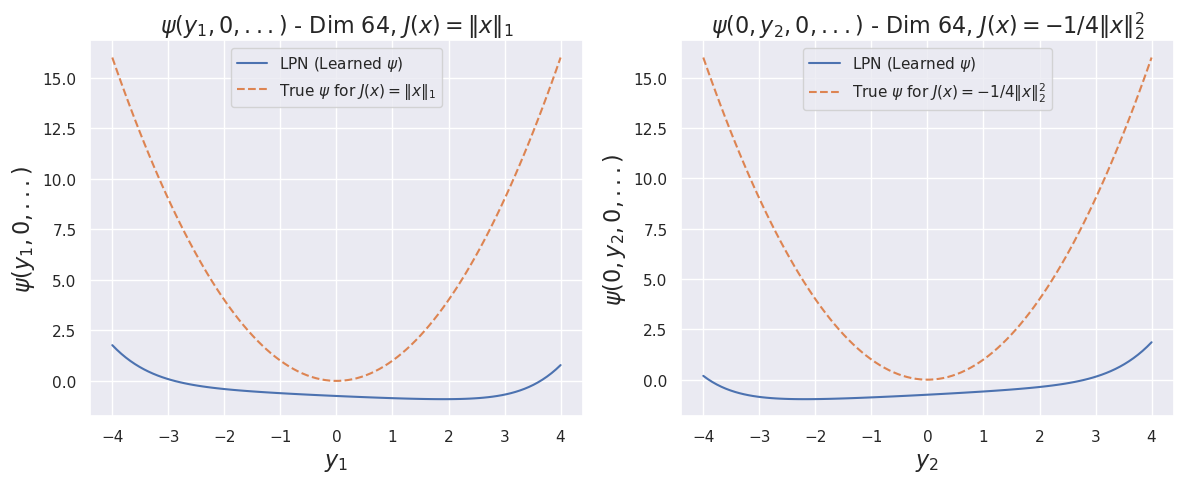

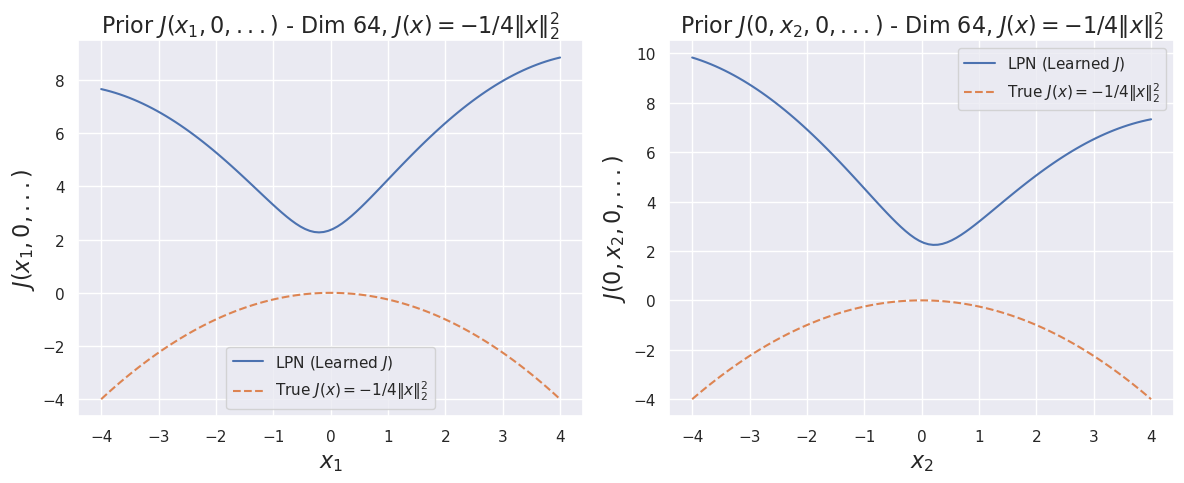

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


tensor([[-1.9903,  1.5706, -6.4792,  ..., -0.7906,  2.6323, -1.0133],
        [-4.3469,  0.8652,  2.0220,  ...,  1.7608, -0.0880,  4.7480],
        [-5.3677, -3.6416,  1.5052,  ...,  6.4210, -2.6778, -6.8157],
        ...,
        [-1.5470, -0.0204,  4.8797,  ...,  1.4861, -6.0400,  3.4188],
        [-2.8677,  4.3135,  5.7030,  ..., -6.2349, -2.8733, -1.4314],
        [ 3.3180,  0.0315, -5.1934,  ...,  3.0662, -4.8422, -6.0567]],
       device='cuda:0')

In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"]/5 # * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 71298.34375
iteration 0 loss 36411.171875


iteration 500 loss 140.43557739257812


iteration 1000 loss 85.87572479248047


iteration 1500 loss 60.251243591308594


iteration 2000 loss 50.26079559326172


iteration 2500 loss 45.92671585083008


iteration 3000 loss 42.942543029785156


iteration 3500 loss 40.106693267822266


iteration 4000 loss 37.25395965576172


iteration 4500 loss 34.42479705810547


iteration 5000 loss 31.679479598999023


iteration 5500 loss 29.0406494140625


iteration 6000 loss 26.478378295898438


iteration 6500 loss 24.007925033569336


iteration 7000 loss 21.635509490966797


iteration 7500 loss 19.358047485351562


iteration 8000 loss 17.216455459594727


iteration 8500 loss 15.248037338256836


iteration 9000 loss 13.437376022338867


iteration 9500 loss 11.815581321716309


iteration 10000 loss 10.394193649291992


iteration 10500 loss 9.138346672058105


iteration 11000 loss 8.143205642700195


iteration 11500 loss 7.317451477050781


iteration 12000 loss 6.764390468597412


iteration 12500 loss 6.160711288452148


iteration 13000 loss 5.7188639640808105


iteration 13500 loss 5.278323173522949


iteration 14000 loss 4.845128059387207


iteration 14500 loss 4.569543838500977


iteration 15000 loss 4.244241237640381


iteration 15500 loss 3.892049789428711


iteration 16000 loss 3.6849515438079834


iteration 16500 loss 3.4473233222961426


iteration 17000 loss 3.1664276123046875


iteration 17500 loss 2.9783124923706055


iteration 18000 loss 2.8264057636260986


iteration 18500 loss 2.642868995666504


iteration 19000 loss 2.4253034591674805


iteration 19500 loss 2.293804407119751


iteration 20000 loss 2.191241502761841


iteration 20500 loss 2.066136360168457


iteration 21000 loss 1.9153772592544556


iteration 21500 loss 1.7718802690505981


iteration 22000 loss 1.701090931892395


iteration 22500 loss 1.6146888732910156


iteration 23000 loss 1.510469913482666


iteration 23500 loss 1.3877419233322144


iteration 24000 loss 1.337917447090149


iteration 24500 loss 1.2875134944915771


iteration 25000 loss 1.2260898351669312


iteration 25500 loss 1.1522897481918335


iteration 26000 loss 1.0659974813461304


iteration 26500 loss 1.0325945615768433


iteration 27000 loss 0.9980441331863403


iteration 27500 loss 0.9558677673339844


iteration 28000 loss 0.9050444960594177


iteration 28500 loss 0.8449815511703491


iteration 29000 loss 0.8207564353942871


iteration 29500 loss 0.797697126865387


iteration 30000 loss 0.7694801688194275


iteration 30500 loss 0.7353202104568481


iteration 31000 loss 0.6946831941604614


iteration 31500 loss 0.6677932739257812


iteration 32000 loss 0.652838945388794


iteration 32500 loss 0.6347413659095764


iteration 33000 loss 0.6125849485397339


iteration 33500 loss 0.5858562588691711


iteration 34000 loss 0.8328059315681458


iteration 34500 loss 0.545437216758728


iteration 35000 loss 0.5323889255523682


iteration 35500 loss 0.5163576006889343


iteration 36000 loss 0.49685296416282654


iteration 36500 loss 0.4735107421875


iteration 37000 loss 0.46624499559402466


iteration 37500 loss 0.4581325650215149


iteration 38000 loss 0.4481809437274933


iteration 38500 loss 0.43589988350868225


iteration 39000 loss 0.42089563608169556


iteration 39500 loss 0.40284451842308044


iteration 40000 loss 0.3976798355579376


iteration 40500 loss 0.3912716805934906


iteration 41000 loss 0.3834820091724396


iteration 41500 loss 0.37384623289108276


iteration 42000 loss 0.3620837926864624


iteration 42500 loss 0.5136815309524536


iteration 43000 loss 0.34426966309547424


iteration 43500 loss 0.3382565379142761


iteration 44000 loss 0.33087772130966187


iteration 44500 loss 0.3217514753341675


iteration 45000 loss 0.31064853072166443


iteration 45500 loss 0.3056533634662628


iteration 46000 loss 0.30148249864578247


iteration 46500 loss 0.29651036858558655


iteration 47000 loss 0.290326327085495


iteration 47500 loss 0.2826613783836365


iteration 48000 loss 0.27330175042152405


iteration 48500 loss 0.2695716321468353


iteration 49000 loss 0.2658942639827728


iteration 49500 loss 0.2614363729953766


iteration 50000 loss 0.25589513778686523


iteration 50500 loss 0.2490634173154831


iteration 51000 loss 0.24508821964263916


iteration 51500 loss 0.2401311993598938


iteration 52000 loss 0.23690453171730042


iteration 52500 loss 0.23301874101161957


iteration 53000 loss 0.22822220623493195


iteration 53500 loss 0.2222498208284378


iteration 54000 loss 0.218858003616333


iteration 54500 loss 0.21561014652252197


iteration 55000 loss 0.21294726431369781


iteration 55500 loss 0.2097163051366806


iteration 56000 loss 0.20570042729377747


iteration 56500 loss 0.20078817009925842


iteration 57000 loss 0.1982903778553009


iteration 57500 loss 0.19458161294460297


iteration 58000 loss 0.192146897315979


iteration 58500 loss 0.18925321102142334


iteration 59000 loss 0.18566276133060455


iteration 59500 loss 0.18152084946632385


iteration 60000 loss 0.17923413217067719


iteration 60500 loss 0.17708827555179596


iteration 61000 loss 0.17500336468219757


iteration 61500 loss 0.17244528234004974


iteration 62000 loss 0.16926051676273346


iteration 62500 loss 0.16534118354320526


iteration 63000 loss 0.16404560208320618


iteration 63500 loss 0.16208434104919434


iteration 64000 loss 0.16025462746620178


iteration 64500 loss 0.15803663432598114


iteration 65000 loss 0.15528284013271332


iteration 65500 loss 0.15204273164272308


iteration 66000 loss 0.15019582211971283


iteration 66500 loss 0.14845821261405945


iteration 67000 loss 0.14681589603424072


iteration 67500 loss 0.14480295777320862


iteration 68000 loss 0.14231359958648682


iteration 68500 loss 0.1393474042415619


iteration 69000 loss 0.13845351338386536


iteration 69500 loss 0.13703715801239014


iteration 70000 loss 0.13545426726341248


iteration 70500 loss 0.1334955096244812


iteration 71000 loss 0.13106441497802734


iteration 71500 loss 0.13092170655727386


iteration 72000 loss 0.12824955582618713


iteration 72500 loss 0.12693864107131958


iteration 73000 loss 0.12550976872444153


iteration 73500 loss 0.123758465051651


iteration 74000 loss 0.12158151715993881


iteration 74500 loss 0.12076039612293243


iteration 75000 loss 0.11895786970853806


iteration 75500 loss 0.11780387908220291


iteration 76000 loss 0.11643929034471512


iteration 76500 loss 0.11473647505044937


iteration 77000 loss 0.11260415613651276


iteration 77500 loss 0.11243001371622086


iteration 78000 loss 0.11096847802400589


iteration 78500 loss 0.1099076122045517


iteration 79000 loss 0.10869137942790985


iteration 79500 loss 0.10729086399078369


iteration 80000 loss 0.10538320243358612


iteration 80500 loss 0.10536232590675354


iteration 81000 loss 0.10379791259765625


iteration 81500 loss 0.10284234583377838


iteration 82000 loss 0.10179232805967331


iteration 82500 loss 0.10053965449333191


iteration 83000 loss 0.09892775863409042


iteration 83500 loss 0.09871283918619156


iteration 84000 loss 0.09697484970092773


iteration 84500 loss 0.09600555151700974


iteration 85000 loss 0.09489494562149048


iteration 85500 loss 0.09352554380893707


iteration 86000 loss 0.09357108175754547


iteration 86500 loss 0.0918072983622551


iteration 87000 loss 0.09086297452449799


iteration 87500 loss 0.08979564905166626


iteration 88000 loss 0.08849196881055832


iteration 88500 loss 0.08905558288097382


iteration 89000 loss 0.08724668622016907


iteration 89500 loss 0.08642494678497314


iteration 90000 loss 0.08561085164546967


iteration 90500 loss 0.08464597165584564


iteration 91000 loss 0.08345483988523483


iteration 91500 loss 0.08378712832927704


iteration 92000 loss 0.08231721073389053


iteration 92500 loss 0.08160796016454697


iteration 93000 loss 0.08087864518165588


iteration 93500 loss 0.08000507950782776


iteration 94000 loss 0.07896779477596283


iteration 94500 loss 0.07945062965154648


iteration 95000 loss 0.07794755697250366


iteration 95500 loss 0.07723873853683472


iteration 96000 loss 0.07653345167636871


iteration 96500 loss 0.07570619881153107


iteration 97000 loss 0.07465322315692902


iteration 97500 loss 0.07468640804290771


iteration 98000 loss 0.07359523326158524


iteration 98500 loss 0.07296483963727951


iteration 99000 loss 0.0722600445151329


iteration 99500 loss 0.0714164525270462


Learning rate decreased to 2e-05 at iteration 100000
iteration 100000 loss 0.07339388877153397


iteration 100500 loss 0.071675606071949


iteration 101000 loss 0.07107950001955032


iteration 101500 loss 0.07063691318035126


iteration 102000 loss 0.07029373943805695


iteration 102500 loss 0.06998879462480545


iteration 103000 loss 0.06967443972826004


iteration 103500 loss 0.06931451708078384


iteration 104000 loss 0.06887859851121902


iteration 104500 loss 0.0683371052145958


iteration 105000 loss 0.0676577016711235


iteration 105500 loss 0.06680534034967422


iteration 106000 loss 0.06598542630672455


iteration 106500 loss 0.06562411040067673


iteration 107000 loss 0.06521304696798325


iteration 107500 loss 0.06469189375638962


iteration 108000 loss 0.06403226405382156


iteration 108500 loss 0.06320126354694366


iteration 109000 loss 0.06254158914089203


iteration 109500 loss 0.06223686411976814


iteration 110000 loss 0.06186206638813019


iteration 110500 loss 0.061386022716760635


iteration 111000 loss 0.060783274471759796


iteration 111500 loss 0.060022495687007904


iteration 112000 loss 0.05937725678086281


iteration 112500 loss 0.059036314487457275


iteration 113000 loss 0.058630697429180145


iteration 113500 loss 0.05811699107289314


iteration 114000 loss 0.05748229846358299


iteration 114500 loss 0.13632002472877502


iteration 115000 loss 0.05647730454802513


iteration 115500 loss 0.05621282756328583


iteration 116000 loss 0.055879589170217514


iteration 116500 loss 0.05545630306005478


iteration 117000 loss 0.05492120981216431


iteration 117500 loss 0.05424590781331062


iteration 118000 loss 0.0537651851773262


iteration 118500 loss 0.05353674665093422


iteration 119000 loss 0.05326443910598755


iteration 119500 loss 0.05291895568370819


iteration 120000 loss 0.05248004570603371


iteration 120500 loss 0.0519254133105278


iteration 121000 loss 0.0886954665184021


iteration 121500 loss 0.051078055053949356


iteration 122000 loss 0.050849299877882004


iteration 122500 loss 0.05056290701031685


iteration 123000 loss 0.05019968003034592


iteration 123500 loss 0.04973970353603363


iteration 124000 loss 0.049160461872816086


iteration 124500 loss 0.04878239706158638


iteration 125000 loss 0.04857734218239784


iteration 125500 loss 0.04832635819911957


iteration 126000 loss 0.048007309436798096


iteration 126500 loss 0.04760241135954857


iteration 127000 loss 0.047100238502025604


iteration 127500 loss 0.046687882393598557


iteration 128000 loss 0.04645467549562454


iteration 128500 loss 0.046238213777542114


iteration 129000 loss 0.04596526548266411


iteration 129500 loss 0.045618828386068344


iteration 130000 loss 0.045179884880781174


iteration 130500 loss 0.044631317257881165


iteration 131000 loss 0.04443851858377457


iteration 131500 loss 0.04423908144235611


iteration 132000 loss 0.04398786649107933


iteration 132500 loss 0.04366835206747055


iteration 133000 loss 0.043277837336063385


iteration 133500 loss 0.04275272786617279


iteration 134000 loss 0.04257504269480705


iteration 134500 loss 0.04240693151950836


iteration 135000 loss 0.04219987243413925


iteration 135500 loss 0.04193688929080963


iteration 136000 loss 0.04160482808947563


iteration 136500 loss 0.04118167608976364


iteration 137000 loss 0.0408293642103672


iteration 137500 loss 0.040637385100126266


iteration 138000 loss 0.04042533040046692


iteration 138500 loss 0.04015681520104408


iteration 139000 loss 0.03981836885213852


iteration 139500 loss 0.039387430995702744


iteration 140000 loss 0.039167240262031555


iteration 140500 loss 0.039020273834466934


iteration 141000 loss 0.03884367644786835


iteration 141500 loss 0.03861939162015915


iteration 142000 loss 0.03833485767245293


iteration 142500 loss 0.03797869756817818


iteration 143000 loss 0.0377032645046711


iteration 143500 loss 0.03745295852422714


iteration 144000 loss 0.03726553916931152


iteration 144500 loss 0.0370301827788353


iteration 145000 loss 0.03673214837908745


iteration 145500 loss 0.03635440766811371


iteration 146000 loss 0.036148734390735626


iteration 146500 loss 0.03601209819316864


iteration 147000 loss 0.03584502637386322


iteration 147500 loss 0.03563274070620537


iteration 148000 loss 0.03536970913410187


iteration 148500 loss 0.035024408251047134


iteration 149000 loss 0.034779563546180725


iteration 149500 loss 0.034647952765226364


iteration 150000 loss 0.03449610248208046


iteration 150500 loss 0.03430336341261864


iteration 151000 loss 0.034058667719364166


iteration 151500 loss 0.03375227376818657


iteration 152000 loss 0.03349948674440384


iteration 152500 loss 0.0333513543009758


iteration 153000 loss 0.033197999000549316


iteration 153500 loss 0.03300387039780617


iteration 154000 loss 0.032758377492427826


iteration 154500 loss 0.032451700419187546


iteration 155000 loss 0.03223828226327896


iteration 155500 loss 0.03210273012518883


iteration 156000 loss 0.031947266310453415


iteration 156500 loss 0.031750522553920746


iteration 157000 loss 0.031500909477472305


iteration 157500 loss 0.031185930594801903


iteration 158000 loss 0.031090233474969864


iteration 158500 loss 0.030971474945545197


iteration 159000 loss 0.03082888387143612


iteration 159500 loss 0.030648626387119293


iteration 160000 loss 0.030421055853366852


iteration 160500 loss 0.030133724212646484


iteration 161000 loss 0.03001008927822113


iteration 161500 loss 0.02990109845995903


iteration 162000 loss 0.029779143631458282


iteration 162500 loss 0.029625432565808296


iteration 163000 loss 0.02943054772913456


iteration 163500 loss 0.029184743762016296


iteration 164000 loss 0.029044121503829956


iteration 164500 loss 0.028873305767774582


iteration 165000 loss 0.02877260372042656


iteration 165500 loss 0.028648965060710907


iteration 166000 loss 0.028492284938693047


iteration 166500 loss 0.028293181210756302


iteration 167000 loss 0.028043419122695923


iteration 167500 loss 0.027905166149139404


iteration 168000 loss 0.02779177762567997


iteration 168500 loss 0.027666378766298294


iteration 169000 loss 0.027508245781064034


iteration 169500 loss 0.027312304824590683


iteration 170000 loss 0.02706233225762844


iteration 170500 loss 0.02696702815592289


iteration 171000 loss 0.026869624853134155


iteration 171500 loss 0.026758750900626183


iteration 172000 loss 0.026618657633662224


iteration 172500 loss 0.026443785056471825


iteration 173000 loss 0.026222607120871544


iteration 173500 loss 0.026080874726176262


iteration 174000 loss 0.02597592957317829


iteration 174500 loss 0.025855420157313347


iteration 175000 loss 0.025702934712171555


iteration 175500 loss 0.02551049366593361


iteration 176000 loss 0.025692308321595192


iteration 176500 loss 0.02524588629603386


iteration 177000 loss 0.025162789970636368


iteration 177500 loss 0.02506314404308796


iteration 178000 loss 0.02493731863796711


iteration 178500 loss 0.02477940544486046


iteration 179000 loss 0.02457801066339016


iteration 179500 loss 0.024451076984405518


iteration 180000 loss 0.02435629814863205


iteration 180500 loss 0.024250496178865433


iteration 181000 loss 0.024116599932312965


iteration 181500 loss 0.023947129026055336


iteration 182000 loss 0.023791341111063957


iteration 182500 loss 0.023686029016971588


iteration 183000 loss 0.02360919862985611


iteration 183500 loss 0.023521805182099342


iteration 184000 loss 0.023411825299263


iteration 184500 loss 0.023272119462490082


iteration 185000 loss 0.023111877962946892


iteration 185500 loss 0.022991038858890533


iteration 186000 loss 0.02288818173110485


iteration 186500 loss 0.02281537652015686


iteration 187000 loss 0.022725462913513184


iteration 187500 loss 0.02261112816631794


iteration 188000 loss 0.022465893998742104


iteration 188500 loss 0.022283654659986496


iteration 189000 loss 0.02219761349260807


iteration 189500 loss 0.022120488807559013


iteration 190000 loss 0.0220300555229187


iteration 190500 loss 0.02191557176411152


iteration 191000 loss 0.021770363673567772


iteration 191500 loss 0.02158668451011181


iteration 192000 loss 0.02152557298541069


iteration 192500 loss 0.02145424671471119


iteration 193000 loss 0.021368371322751045


iteration 193500 loss 0.02125953882932663


iteration 194000 loss 0.02112174592912197


iteration 194500 loss 0.020947912707924843


iteration 195000 loss 0.02090040221810341


iteration 195500 loss 0.02083594724535942


iteration 196000 loss 0.020764393731951714


iteration 196500 loss 0.020674556493759155


iteration 197000 loss 0.020562930032610893


iteration 197500 loss 0.020416442304849625


iteration 198000 loss 0.020367993041872978


iteration 198500 loss 0.020212624222040176


iteration 199000 loss 0.020140334963798523


iteration 199500 loss 0.020051391795277596


Learning rate decreased to 4.000000000000001e-06 at iteration 200000
iteration 200000 loss 0.019938630983233452


iteration 200500 loss 0.019909117370843887


iteration 201000 loss 0.019872058182954788


iteration 201500 loss 0.019824858754873276


iteration 202000 loss 0.0197642520070076


iteration 202500 loss 0.019686928018927574


iteration 203000 loss 0.01958823762834072


iteration 203500 loss 0.019462663680315018


iteration 204000 loss 0.01930355280637741


iteration 204500 loss 0.019249670207500458


iteration 205000 loss 0.019198723137378693


iteration 205500 loss 0.019133426249027252


iteration 206000 loss 0.019050216302275658


iteration 206500 loss 0.018944337964057922


iteration 207000 loss 0.01880953460931778


iteration 207500 loss 0.01868804544210434


iteration 208000 loss 0.01864462159574032


iteration 208500 loss 0.01859022118151188


iteration 209000 loss 0.01852056197822094


iteration 209500 loss 0.01843170076608658


iteration 210000 loss 0.018318666145205498


iteration 210500 loss 0.01817537099123001


iteration 211000 loss 0.018110033124685287


iteration 211500 loss 0.018062837421894073


iteration 212000 loss 0.01800219714641571


iteration 212500 loss 0.017925044521689415


iteration 213000 loss 0.017826717346906662


iteration 213500 loss 0.017701871693134308


iteration 214000 loss 0.017594637349247932


iteration 214500 loss 0.017541972920298576


iteration 215000 loss 0.017474832013249397


iteration 215500 loss 0.017389221116900444


iteration 216000 loss 0.01728033274412155


iteration 216500 loss 0.01714266650378704


iteration 217000 loss 0.0171036534011364


iteration 217500 loss 0.017058726400136948


iteration 218000 loss 0.017001140862703323


iteration 218500 loss 0.016927754506468773


iteration 219000 loss 0.01683422550559044


iteration 219500 loss 0.01671537384390831


iteration 220000 loss 0.016623904928565025


iteration 220500 loss 0.016580617055296898


iteration 221000 loss 0.01652522198855877


iteration 221500 loss 0.016454556956887245


iteration 222000 loss 0.016364598646759987


iteration 222500 loss 0.016250329092144966


iteration 223000 loss 0.016167229041457176


iteration 223500 loss 0.016131427139043808


iteration 224000 loss 0.01608606055378914


iteration 224500 loss 0.016027966514229774


iteration 225000 loss 0.01595385931432247


iteration 225500 loss 0.015859700739383698


iteration 226000 loss 0.01574021205306053


iteration 226500 loss 0.015685085207223892


iteration 227000 loss 0.015633471310138702


iteration 227500 loss 0.015567701309919357


iteration 228000 loss 0.015483813360333443


iteration 228500 loss 0.015377105213701725


iteration 229000 loss 0.015300856903195381


iteration 229500 loss 0.01526495348662138


iteration 230000 loss 0.01521956454962492


iteration 230500 loss 0.01516131591051817


iteration 231000 loss 0.015087176114320755


iteration 231500 loss 0.014992989599704742


iteration 232000 loss 0.014896713197231293


iteration 232500 loss 0.014863714575767517


iteration 233000 loss 0.014825453981757164


iteration 233500 loss 0.014776458032429218


iteration 234000 loss 0.014713955111801624


iteration 234500 loss 0.014634634368121624


iteration 235000 loss 0.014533402398228645


iteration 235500 loss 0.014463614672422409


iteration 236000 loss 0.014426516368985176


iteration 236500 loss 0.014379244297742844


iteration 237000 loss 0.014318990521132946


iteration 237500 loss 0.014242161065340042


iteration 238000 loss 0.014144646935164928


iteration 238500 loss 0.014085917733609676


iteration 239000 loss 0.014049678109586239


iteration 239500 loss 0.014003144577145576


iteration 240000 loss 0.0139438072219491


iteration 240500 loss 0.013868560083210468


iteration 241000 loss 0.013772179372608662


iteration 241500 loss 0.013724310323596


iteration 242000 loss 0.013691503554582596


iteration 242500 loss 0.013649673201143742


iteration 243000 loss 0.01359617244452238


iteration 243500 loss 0.013528098352253437


iteration 244000 loss 0.013441669754683971


iteration 244500 loss 0.013370513916015625


iteration 245000 loss 0.01333614345639944


iteration 245500 loss 0.013292324729263783


iteration 246000 loss 0.013236431404948235


iteration 246500 loss 0.0131651870906353


iteration 247000 loss 0.01307549700140953


iteration 247500 loss 0.013025790452957153


iteration 248000 loss 0.012990646064281464


iteration 248500 loss 0.012945684604346752


iteration 249000 loss 0.012888344936072826


iteration 249500 loss 0.012815682217478752


iteration 250000 loss 0.012780311517417431


iteration 250500 loss 0.012696891091763973


iteration 251000 loss 0.012660657986998558


iteration 251500 loss 0.012614313513040543


iteration 252000 loss 0.012555312365293503


iteration 252500 loss 0.012480152770876884


iteration 253000 loss 0.01240585744380951


iteration 253500 loss 0.012377377599477768


iteration 254000 loss 0.012342075817286968


iteration 254500 loss 0.012296898290514946


iteration 255000 loss 0.012239434756338596


iteration 255500 loss 0.012166210450232029


iteration 256000 loss 0.012098176404833794


iteration 256500 loss 0.01207016222178936


iteration 257000 loss 0.012035766616463661


iteration 257500 loss 0.011991776525974274


iteration 258000 loss 0.01193570252507925


iteration 258500 loss 0.011864411644637585


iteration 259000 loss 0.011798502877354622


iteration 259500 loss 0.011768793687224388


iteration 260000 loss 0.011731788516044617


iteration 260500 loss 0.011684427969157696


iteration 261000 loss 0.011624074541032314


iteration 261500 loss 0.01154755987226963


iteration 262000 loss 0.011510569602251053


iteration 262500 loss 0.011482897214591503


iteration 263000 loss 0.01144764106720686


iteration 263500 loss 0.011402536183595657


iteration 264000 loss 0.011345022358000278


iteration 264500 loss 0.0112719452008605


iteration 265000 loss 0.011232520453631878


iteration 265500 loss 0.011207266710698605


iteration 266000 loss 0.011175211519002914


iteration 266500 loss 0.011134205386042595


iteration 267000 loss 0.011082236655056477


iteration 267500 loss 0.011015656404197216


iteration 268000 loss 0.010966373607516289


iteration 268500 loss 0.010945399291813374


iteration 269000 loss 0.01091937255114317


iteration 269500 loss 0.010886234231293201


iteration 270000 loss 0.010843724012374878


iteration 270500 loss 0.010789795778691769


iteration 271000 loss 0.0107211172580719


iteration 271500 loss 0.010687388479709625


iteration 272000 loss 0.010665994137525558


iteration 272500 loss 0.010639052838087082


iteration 273000 loss 0.010604643262922764


iteration 273500 loss 0.010560734197497368


iteration 274000 loss 0.01050493959337473


iteration 274500 loss 0.010591087862849236


iteration 275000 loss 0.01041352842003107


iteration 275500 loss 0.010383091866970062


iteration 276000 loss 0.010344251058995724


iteration 276500 loss 0.010294788517057896


iteration 277000 loss 0.010231916792690754


iteration 277500 loss 0.010197398252785206


iteration 278000 loss 0.010177373886108398


iteration 278500 loss 0.010152213275432587


iteration 279000 loss 0.010120043531060219


iteration 279500 loss 0.010078927502036095


iteration 280000 loss 0.010026687756180763


iteration 280500 loss 0.010285098105669022


iteration 281000 loss 0.009941230528056622


iteration 281500 loss 0.009912699460983276


iteration 282000 loss 0.009876211173832417


iteration 282500 loss 0.009829732589423656


iteration 283000 loss 0.00977123249322176


iteration 283500 loss 0.009737925603985786


iteration 284000 loss 0.009719442576169968


iteration 284500 loss 0.009696390479803085


iteration 285000 loss 0.00966707058250904


iteration 285500 loss 0.009629541076719761


iteration 286000 loss 0.009581826627254486


iteration 286500 loss 0.009521238505840302


iteration 287000 loss 0.009499456733465195


iteration 287500 loss 0.009477613493800163


iteration 288000 loss 0.009449785575270653


iteration 288500 loss 0.009414145722985268


iteration 289000 loss 0.00936888437718153


iteration 289500 loss 0.009311349131166935


iteration 290000 loss 0.009284155443310738


iteration 290500 loss 0.0092608742415905


iteration 291000 loss 0.009231298230588436


iteration 291500 loss 0.009193448349833488


iteration 292000 loss 0.009145393967628479


iteration 292500 loss 0.009096612222492695


iteration 293000 loss 0.009078917093575


iteration 293500 loss 0.009059528820216656


iteration 294000 loss 0.009035049006342888


iteration 294500 loss 0.009003682062029839


iteration 295000 loss 0.008963758125901222


iteration 295500 loss 0.008913432247936726


iteration 296000 loss 0.008877331390976906


iteration 296500 loss 0.008855787105858326


iteration 297000 loss 0.008828536607325077


iteration 297500 loss 0.008793727494776249


iteration 298000 loss 0.008749556727707386


iteration 298500 loss 0.008715013042092323


iteration 299000 loss 0.008680063299834728


iteration 299500 loss 0.008656925521790981


Learning rate decreased to 8.000000000000002e-07 at iteration 300000
iteration 300000 loss 0.008627449162304401


iteration 300500 loss 0.008620243519544601


iteration 301000 loss 0.00861061830073595


iteration 301500 loss 0.008597955107688904


iteration 302000 loss 0.008581763133406639


iteration 302500 loss 0.008561346679925919


iteration 303000 loss 0.008535328321158886


iteration 303500 loss 0.008502138778567314


iteration 304000 loss 0.008459961041808128


iteration 304500 loss 0.008410788141191006


iteration 305000 loss 0.008391385897994041


iteration 305500 loss 0.008367424830794334


iteration 306000 loss 0.008336769416928291


iteration 306500 loss 0.008297844789922237


iteration 307000 loss 0.008248544298112392


iteration 307500 loss 0.008223357610404491


iteration 308000 loss 0.008200481534004211


iteration 308500 loss 0.008171276189386845


iteration 309000 loss 0.008134013041853905


iteration 309500 loss 0.008086913265287876


iteration 310000 loss 0.008059417828917503


iteration 310500 loss 0.008034888654947281


iteration 311000 loss 0.008003492839634418


iteration 311500 loss 0.00796369556337595


iteration 312000 loss 0.00791956391185522


iteration 312500 loss 0.007896186783909798


iteration 313000 loss 0.007866252213716507


iteration 313500 loss 0.007828217931091785


iteration 314000 loss 0.007783182896673679


iteration 314500 loss 0.007762943860143423


iteration 315000 loss 0.007737487554550171


iteration 315500 loss 0.007704940624535084


iteration 316000 loss 0.0076637547463178635


iteration 316500 loss 0.007632510270923376


iteration 317000 loss 0.007614176720380783


iteration 317500 loss 0.007590952794998884


iteration 318000 loss 0.007561135105788708


iteration 318500 loss 0.007523367181420326


iteration 319000 loss 0.007485273759812117


iteration 319500 loss 0.007467678748071194


iteration 320000 loss 0.007445330731570721


iteration 320500 loss 0.0074167377315461636


iteration 321000 loss 0.007380492985248566


iteration 321500 loss 0.007341125980019569


iteration 322000 loss 0.007319245953112841


iteration 322500 loss 0.0072912476025521755


iteration 323000 loss 0.007255700416862965


iteration 323500 loss 0.007218057289719582


iteration 324000 loss 0.007201234344393015


iteration 324500 loss 0.007179862819612026


iteration 325000 loss 0.007152465637773275


iteration 325500 loss 0.007117744069546461


iteration 326000 loss 0.007080495823174715


iteration 326500 loss 0.007060176692903042


iteration 327000 loss 0.007034174166619778


iteration 327500 loss 0.0070011732168495655


iteration 328000 loss 0.0069628143683075905


iteration 328500 loss 0.006947457790374756


iteration 329000 loss 0.006928202696144581


iteration 329500 loss 0.0069036297500133514


iteration 330000 loss 0.006872301921248436


iteration 330500 loss 0.006833056453615427


iteration 331000 loss 0.006813891232013702


iteration 331500 loss 0.0067905220203101635


iteration 332000 loss 0.006760674994438887


iteration 332500 loss 0.006722928490489721


iteration 333000 loss 0.006705935578793287


iteration 333500 loss 0.0066887191496789455


iteration 334000 loss 0.006666751578450203


iteration 334500 loss 0.006638687569648027


iteration 335000 loss 0.006603194400668144


iteration 335500 loss 0.006581075955182314


iteration 336000 loss 0.006562912371009588


iteration 336500 loss 0.006539697293192148


iteration 337000 loss 0.006510111968964338


iteration 337500 loss 0.006477842573076487


iteration 338000 loss 0.0064615788869559765


iteration 338500 loss 0.006445602048188448


iteration 339000 loss 0.006425308063626289


iteration 339500 loss 0.0063993195071816444


iteration 340000 loss 0.006366438698023558


iteration 340500 loss 0.006343991495668888


iteration 341000 loss 0.0063294521532952785


iteration 341500 loss 0.006311063189059496


iteration 342000 loss 0.006287645548582077


iteration 342500 loss 0.006257766392081976


iteration 343000 loss 0.00622835848480463


iteration 343500 loss 0.006211175117641687


iteration 344000 loss 0.0061891814693808556


iteration 344500 loss 0.006161161232739687


iteration 345000 loss 0.0061296140775084496


iteration 345500 loss 0.006118025165051222


iteration 346000 loss 0.006103323772549629


iteration 346500 loss 0.006084730848670006


iteration 347000 loss 0.006060984451323748


iteration 347500 loss 0.006030907854437828


iteration 348000 loss 0.006007956340909004


iteration 348500 loss 0.005993220489472151


iteration 349000 loss 0.005974458996206522


iteration 349500 loss 0.0059505305252969265


iteration 350000 loss 0.005920157767832279


iteration 350500 loss 0.005900987423956394


iteration 351000 loss 0.005886771250516176


iteration 351500 loss 0.005868842359632254


iteration 352000 loss 0.005845861975103617


iteration 352500 loss 0.005816743243485689


iteration 353000 loss 0.005795941222459078


iteration 353500 loss 0.005781989544630051


iteration 354000 loss 0.005764306522905827


iteration 354500 loss 0.005741802044212818


iteration 355000 loss 0.005713183432817459


iteration 355500 loss 0.005693548824638128


iteration 356000 loss 0.005680513568222523


iteration 356500 loss 0.005663924850523472


iteration 357000 loss 0.00564279081299901


iteration 357500 loss 0.0056159053929150105


iteration 358000 loss 0.005593928508460522


iteration 358500 loss 0.005581978242844343


iteration 359000 loss 0.00556690338999033


iteration 359500 loss 0.0055477251298725605


iteration 360000 loss 0.005523343104869127


iteration 360500 loss 0.005495848599821329


iteration 361000 loss 0.005482804030179977


iteration 361500 loss 0.005466348025947809


iteration 362000 loss 0.0054453033953905106


iteration 362500 loss 0.005418587941676378


iteration 363000 loss 0.005399505607783794


iteration 363500 loss 0.0053857252933084965


iteration 364000 loss 0.00536819314584136


iteration 364500 loss 0.005345760844647884


iteration 365000 loss 0.005317466799169779


iteration 365500 loss 0.005304108839482069


iteration 366000 loss 0.005288137588649988


iteration 366500 loss 0.005267713684588671


iteration 367000 loss 0.005241790786385536


iteration 367500 loss 0.005223941057920456


iteration 368000 loss 0.005209831986576319


iteration 368500 loss 0.0051917750388383865


iteration 369000 loss 0.005168797913938761


iteration 369500 loss 0.0051458473317325115


iteration 370000 loss 0.005136571358889341


iteration 370500 loss 0.00512471329420805


iteration 371000 loss 0.005109701305627823


iteration 371500 loss 0.0050906827673316


iteration 372000 loss 0.005066377110779285


iteration 372500 loss 0.005049511790275574


iteration 373000 loss 0.005038605537265539


iteration 373500 loss 0.005024807993322611


iteration 374000 loss 0.005007291212677956


iteration 374500 loss 0.004984944127500057


iteration 375000 loss 0.004964333027601242


iteration 375500 loss 0.004954376257956028


iteration 376000 loss 0.0049417894333601


iteration 376500 loss 0.004925887566059828


iteration 377000 loss 0.004905612673610449


iteration 377500 loss 0.0048975409008562565


iteration 378000 loss 0.004872554447501898


iteration 378500 loss 0.00486193411052227


iteration 379000 loss 0.004848560784012079


iteration 379500 loss 0.004831521771848202


iteration 380000 loss 0.004809830337762833


iteration 380500 loss 0.004791107960045338


iteration 381000 loss 0.004781525582075119


iteration 381500 loss 0.004769372288137674


iteration 382000 loss 0.004754005931317806


iteration 382500 loss 0.004734400659799576


iteration 383000 loss 0.004711105953902006


iteration 383500 loss 0.004702336620539427


iteration 384000 loss 0.004691195208579302


iteration 384500 loss 0.004677044693380594


iteration 385000 loss 0.004659145139157772


iteration 385500 loss 0.0046363468281924725


iteration 386000 loss 0.004624949302524328


iteration 386500 loss 0.004615974146872759


iteration 387000 loss 0.00460459990426898


iteration 387500 loss 0.004590225871652365


iteration 388000 loss 0.004571957513689995


iteration 388500 loss 0.004548725672066212


iteration 389000 loss 0.004538323730230331


iteration 389500 loss 0.004525767173618078


iteration 390000 loss 0.004509854596108198


iteration 390500 loss 0.00448952242732048


iteration 391000 loss 0.004473213106393814


iteration 391500 loss 0.004464281257241964


iteration 392000 loss 0.004452942870557308


iteration 392500 loss 0.004438639618456364


iteration 393000 loss 0.0044204192236065865


iteration 393500 loss 0.004399565979838371


iteration 394000 loss 0.004392618779093027


iteration 394500 loss 0.004384255036711693


iteration 395000 loss 0.004373624455183744


iteration 395500 loss 0.0043601891957223415


iteration 396000 loss 0.004343120381236076


iteration 396500 loss 0.004321415442973375


iteration 397000 loss 0.0043123564682900906


iteration 397500 loss 0.004302877467125654


iteration 398000 loss 0.0042909360490739346


iteration 398500 loss 0.004275796469300985


iteration 399000 loss 0.004256510175764561


iteration 399500 loss 0.0042429170571267605


Learning rate decreased to 1.6000000000000003e-07 at iteration 400000
iteration 400000 loss 0.00423572538420558


iteration 400500 loss 0.004234110936522484


iteration 401000 loss 0.004232064820826054


iteration 401500 loss 0.004229302052408457


iteration 402000 loss 0.004225682932883501


iteration 402500 loss 0.0042209262028336525


iteration 403000 loss 0.004214567597955465


iteration 403500 loss 0.004206400364637375


iteration 404000 loss 0.0041960920207202435


iteration 404500 loss 0.004183249548077583


iteration 405000 loss 0.004167487844824791


iteration 405500 loss 0.004148230422288179


iteration 406000 loss 0.004128028638660908


iteration 406500 loss 0.004108039196580648


iteration 407000 loss 0.004087755922228098


iteration 407500 loss 0.004067976493388414


iteration 408000 loss 0.0040480466559529305


iteration 408500 loss 0.004028387367725372


iteration 409000 loss 0.004008664283901453


iteration 409500 loss 0.003989039920270443


iteration 410000 loss 0.003969996701925993


iteration 410500 loss 0.003950641490519047


iteration 411000 loss 0.0039313919842243195


iteration 411500 loss 0.003912628628313541


iteration 412000 loss 0.0038943735416978598


iteration 412500 loss 0.003875539405271411


iteration 413000 loss 0.0038568477611988783


iteration 413500 loss 0.0038385260850191116


iteration 414000 loss 0.0038199485279619694


iteration 414500 loss 0.0038014689926058054


iteration 415000 loss 0.003783514956012368


iteration 415500 loss 0.0037651832681149244


iteration 416000 loss 0.0037470601964741945


iteration 416500 loss 0.003729158779606223


iteration 417000 loss 0.003711205907166004


iteration 417500 loss 0.003693804843351245


iteration 418000 loss 0.0036763777025043964


iteration 418500 loss 0.0036587819922715425


iteration 419000 loss 0.0036413276102393866


iteration 419500 loss 0.0036239726468920708


iteration 420000 loss 0.003606935730203986


iteration 420500 loss 0.003590361215174198


iteration 421000 loss 0.003573422087356448


iteration 421500 loss 0.0035564356949180365


iteration 422000 loss 0.003540386911481619


iteration 422500 loss 0.003523631254211068


iteration 423000 loss 0.003507259301841259


iteration 423500 loss 0.0034908961970359087


iteration 424000 loss 0.0034747847821563482


iteration 424500 loss 0.0034584205131977797


iteration 425000 loss 0.0034423910547047853


iteration 425500 loss 0.0034266398288309574


iteration 426000 loss 0.0034105260856449604


iteration 426500 loss 0.0033945837058126926


iteration 427000 loss 0.0033791030291467905


iteration 427500 loss 0.0033634521532803774


iteration 428000 loss 0.0033476012758910656


iteration 428500 loss 0.00333206239156425


iteration 429000 loss 0.0033173388801515102


iteration 429500 loss 0.003301705466583371


iteration 430000 loss 0.003286251798272133


iteration 430500 loss 0.0032714572735130787


iteration 431000 loss 0.003256896510720253


iteration 431500 loss 0.0032415969762951136


iteration 432000 loss 0.003226539818570018


iteration 432500 loss 0.0032123480923473835


iteration 433000 loss 0.003198386402800679


iteration 433500 loss 0.0031837003771215677


iteration 434000 loss 0.0031706802546977997


iteration 434500 loss 0.0031560424249619246


iteration 435000 loss 0.003143017180263996


iteration 435500 loss 0.003128605894744396


iteration 436000 loss 0.0031154167372733355


iteration 436500 loss 0.0031008380465209484


iteration 437000 loss 0.003087592776864767


iteration 437500 loss 0.003073756815865636


iteration 438000 loss 0.0030597031582146883


iteration 438500 loss 0.0030465221498161554


iteration 439000 loss 0.00303241447545588


iteration 439500 loss 0.0030190441757440567


iteration 440000 loss 0.0030060007702559233


iteration 440500 loss 0.002992501249536872


iteration 441000 loss 0.002979321638122201


iteration 441500 loss 0.0029657436534762383


iteration 442000 loss 0.0029529440216720104


iteration 442500 loss 0.0029396889731287956


iteration 443000 loss 0.0029259833972901106


iteration 443500 loss 0.0029139139223843813


iteration 444000 loss 0.002900750609114766


iteration 444500 loss 0.0028880371246486902


iteration 445000 loss 0.002875090343877673


iteration 445500 loss 0.002862001769244671


iteration 446000 loss 0.00285023613832891


iteration 446500 loss 0.002837345004081726


iteration 447000 loss 0.002824732568114996


iteration 447500 loss 0.0028121371287852526


iteration 448000 loss 0.0028001037426292896


iteration 448500 loss 0.0027883979491889477


iteration 449000 loss 0.0027765552513301373


iteration 449500 loss 0.0027644617948681116


iteration 450000 loss 0.002752384403720498


iteration 450500 loss 0.0027408336754888296


iteration 451000 loss 0.002728723920881748


iteration 451500 loss 0.002716947579756379


iteration 452000 loss 0.0027056506369262934


iteration 452500 loss 0.002693575108423829


iteration 453000 loss 0.00268187141045928


iteration 453500 loss 0.0026700168382376432


iteration 454000 loss 0.002658829325810075


iteration 454500 loss 0.002647608518600464


iteration 455000 loss 0.0026362845674157143


iteration 455500 loss 0.002624731743708253


iteration 456000 loss 0.0026127577293664217


iteration 456500 loss 0.0026022265665233135


iteration 457000 loss 0.002591111231595278


iteration 457500 loss 0.0025807642377913


iteration 458000 loss 0.002569497562944889


iteration 458500 loss 0.0025580821093171835


iteration 459000 loss 0.00254807248711586


iteration 459500 loss 0.002536975545808673


iteration 460000 loss 0.002526384312659502


iteration 460500 loss 0.002515227533876896


iteration 461000 loss 0.002505525480955839


iteration 461500 loss 0.0024943954776972532


iteration 462000 loss 0.0024848429020494223


iteration 462500 loss 0.0024746558628976345


iteration 463000 loss 0.002464618533849716


iteration 463500 loss 0.002454769564792514


iteration 464000 loss 0.002444481709972024


iteration 464500 loss 0.0024352590553462505


iteration 465000 loss 0.002424667589366436


iteration 465500 loss 0.0024150253739207983


iteration 466000 loss 0.0024050127249211073


iteration 466500 loss 0.002395666902884841


iteration 467000 loss 0.0023850789293646812


iteration 467500 loss 0.002376131247729063


iteration 468000 loss 0.002366343280300498


iteration 468500 loss 0.0023564163129776716


iteration 469000 loss 0.002346964320167899


iteration 469500 loss 0.0023373684380203485


iteration 470000 loss 0.0023278100416064262


iteration 470500 loss 0.0023185687605291605


iteration 471000 loss 0.0023094855714589357


iteration 471500 loss 0.0022996929474174976


iteration 472000 loss 0.002291173906996846


iteration 472500 loss 0.0022810958325862885


iteration 473000 loss 0.0022719120606780052


iteration 473500 loss 0.002262649592012167


iteration 474000 loss 0.0022546080872416496


iteration 474500 loss 0.0022449279204010963


iteration 475000 loss 0.0022363532334566116


iteration 475500 loss 0.002227271208539605


iteration 476000 loss 0.0022179146762937307


iteration 476500 loss 0.00220864568836987


iteration 477000 loss 0.002199925482273102


iteration 477500 loss 0.0021904287859797478


iteration 478000 loss 0.002182070864364505


iteration 478500 loss 0.002173027256503701


iteration 479000 loss 0.002163391560316086


iteration 479500 loss 0.0021546646021306515


iteration 480000 loss 0.0021451637148857117


iteration 480500 loss 0.0021370779722929


iteration 481000 loss 0.0021287016570568085


iteration 481500 loss 0.0021193630527704954


iteration 482000 loss 0.0021104488987475634


iteration 482500 loss 0.0021022839937359095


iteration 483000 loss 0.0020939267706125975


iteration 483500 loss 0.0020843669772148132


iteration 484000 loss 0.0020751659758388996


iteration 484500 loss 0.002066107001155615


iteration 485000 loss 0.002057622652500868


iteration 485500 loss 0.0020487364381551743


iteration 486000 loss 0.0020396753679960966


iteration 486500 loss 0.0020310436375439167


iteration 487000 loss 0.0020222195889800787


iteration 487500 loss 0.002013471443206072


iteration 488000 loss 0.002005293732509017


iteration 488500 loss 0.0019964994862675667


iteration 489000 loss 0.0019880649633705616


iteration 489500 loss 0.001979533117264509


iteration 490000 loss 0.001970822922885418


iteration 490500 loss 0.001962290843948722


iteration 491000 loss 0.0019537874031811953


iteration 491500 loss 0.001945413532666862


iteration 492000 loss 0.0019370891386643052


iteration 492500 loss 0.0019286854658275843


iteration 493000 loss 0.0019202472176402807


iteration 493500 loss 0.001912086270749569


iteration 494000 loss 0.001903981901705265


iteration 494500 loss 0.0018958080327138305


iteration 495000 loss 0.0018881401047110558


iteration 495500 loss 0.0018802356207743287


iteration 496000 loss 0.001872143941000104


iteration 496500 loss 0.0018641211790964007


iteration 497000 loss 0.0018562087789177895


iteration 497500 loss 0.0018485196633264422


iteration 498000 loss 0.0018406262388452888


iteration 498500 loss 0.0018327741418033838


iteration 499000 loss 0.0018249106360599399


iteration 499500 loss 0.0018172628479078412


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


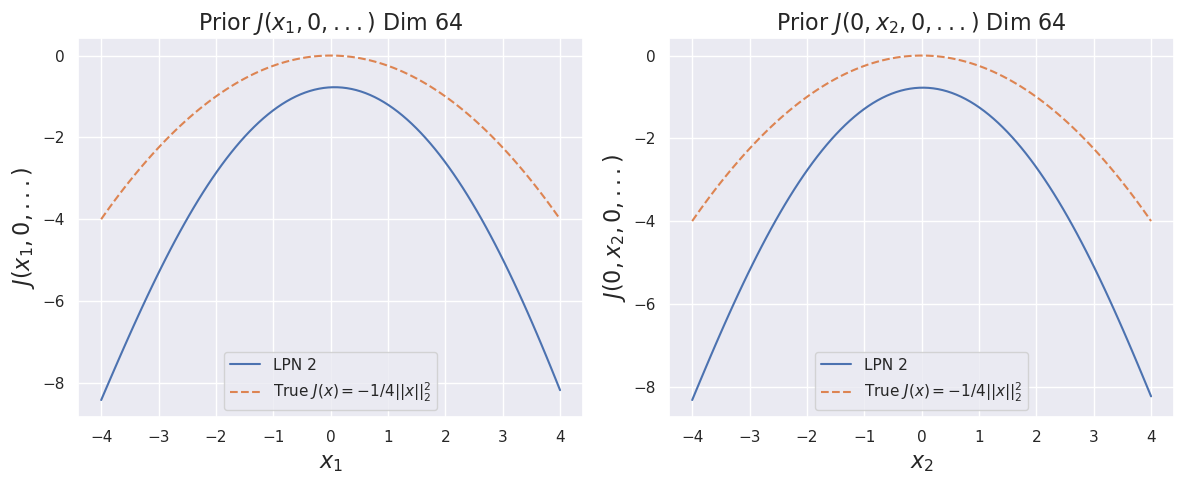

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}",fontsize=16)
    plt.xlabel('$x_1$',fontsize=16)
    plt.ylabel('$J(x_1,0,...)$',fontsize=16)
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}",fontsize=16)
        plt.xlabel('$x_2$',fontsize=16)
        plt.ylabel('$J(0,x_2,0,...)$',fontsize=16)
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)